# Geo-navigation with Strapdown Sim

We'll use this notebook to explore geophysical map-matching to aid degraded INS navigation.

First let's pull the coordinates and develop a measurement model parameters for magnetic and gravity anomaly maps

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import pandas as pd
import pygmt
from haversine import haversine_vector, Unit
from matplotlib import pyplot as plt
from matplotlib.figure import Figure, SubFigure
from cartopy import crs as ccrs
from cartopy.io import img_tiles as cimgt
from typing import Optional
import xarray as xr


ROOT = Path(".").resolve()

def find_strapdown_bin() -> Path:
    if "STRAPDOWN_BIN" in os.environ:
        return Path(os.environ["STRAPDOWN_BIN"])
    exe = "strapdown-sim.exe" if sys.platform.startswith("win") else "strapdown-sim"
    cand = Path().resolve().parents[1] / "target" / "release" / exe
    if cand.exists():
        return cand
    raise FileNotFoundError("strapdown-sim not found. Build with `pixi run cargo build --workspace --release`.")

def find_geonav_bin() -> Path:
    if "GEONAV_BIN" in os.environ:
        return Path(os.environ["GEONAV_BIN"])
    exe = "geonav-sim.exe" if sys.platform.startswith("win") else "geonav-sim"
    cand = Path().resolve().parents[1] / "target" / "release" / exe
    if cand.exists():
        return cand
    raise FileNotFoundError("geonav-sim not found. Build with `pixi run cargo build --workspace --release`.")


def plot_results(scenario:str, title_str:str = "") -> Figure | SubFigure:
    """Performance visualization plot helper"""
    truth = pd.read_csv(ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True)
    df = pd.read_csv(ROOT.joinpath("out", f'{scenario}.csv'), index_col=0, parse_dates=True)
    truth_coords = truth[["latitude", "longitude", "altitude"]].copy().to_numpy()
    df_coords = df[["latitude", "longitude", "altitude"]].copy().to_numpy()

    two_d_error = haversine_vector(truth_coords[1:, :2], df_coords[1:, :2], Unit.METERS)
    time = (df.index - df.index[0]).total_seconds()
    plt.figure(figsize=(18, 6))
    plt.plot(time[1:], two_d_error)

    plt.xlim(left=0)
    plt.ylim((0, 150))

    plt.xlabel('Time (s)')
    plt.ylabel('Haversine Error (m)')
    plt.title(f'Simulation: {title_str}')
    #plt.legend()
    plt.grid()
    return plt.gcf()


def inflate_bounds(
    min_x: float, min_y: float, max_x: float, max_y: float, inflation_percent: float
) -> tuple[float, float, float, float]:
    width = max_x - min_x
    height = max_y - min_y
    if width <= 1e-6:
        width = 0.1
    if height <= 1e-6:
        height = 0.1
    inflate_x = width * inflation_percent
    inflate_y = height * inflation_percent
    new_min_x = min_x - inflate_x
    new_min_y = min_y - inflate_y
    new_max_x = max_x + inflate_x
    new_max_y = max_y + inflate_y
    return new_min_x, new_min_y, new_max_x, new_max_y


def plot_route(cleaned_data: pd.DataFrame, output_path: str | Path, title: Optional[str] = None) -> Figure | SubFigure:
    """
    Plot the route from cleaned data and save to output_path.
    """
    west_lon = cleaned_data["longitude"].min()
    east_lon = cleaned_data["longitude"].max()
    south_lat = cleaned_data["latitude"].min()
    north_lat = cleaned_data["latitude"].max()
    west_lon, south_lat, east_lon, north_lat = inflate_bounds(west_lon, south_lat, east_lon, north_lat, 0.1)
    extent = [west_lon, east_lon, south_lat, north_lat]
    request = cimgt.GoogleTiles()
    ax = plt.axes(projection=request.crs)
    ax.set_extent(extent)  # type: ignore
    ax.add_image(request, 15)  # type: ignore
    ax.scatter(
        cleaned_data["longitude"],
        cleaned_data["latitude"],
        0.5,
        color="red",
        transform=ccrs.PlateCarree(),
    )
    if title:
        ax.set_title(title)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Route plot saved to {output_path}.")
    return ax.figure

In [2]:
coords = np.empty((0, 3))  # lat, lon, alt
grav = np.empty((0, 3)) 
mag = np.empty((0, 3))  

In [3]:
from glob import glob

for file in glob("../../data/input/*.csv"):
    print(f"Reading {file}")
    data = pd.read_csv(file, index_col=0, parse_dates=True)
    data = data.dropna(subset=["latitude", "longitude", "altitude", "grav_x", "grav_y", "grav_z", "mag_x", "mag_y", "mag_z"])
    grav = np.vstack((grav, data[["grav_x", "grav_y", "grav_z"]].values))
    mag = np.vstack((mag, data[["mag_x", "mag_y", "mag_z"]].values))
    coords = np.vstack((coords, data[["latitude", "longitude", "altitude"]].values))

Reading ../../data/input/2025-06-18_15-09-25.csv
Reading ../../data/input/2025-06-14_21-17-02.csv
Reading ../../data/input/2023-08-09_124742.csv
Reading ../../data/input/2025-07-08_14-12-53.csv
Reading ../../data/input/2025-07-31_23-36-03.csv
Reading ../../data/input/2024-06-20_165550.csv
Reading ../../data/input/2025-03-01_150426.csv
Reading ../../data/input/2025-06-27_11-54-35.csv
Reading ../../data/input/2025-07-04_17-24-46.csv
Reading ../../data/input/2023-08-06_144805.csv
Reading ../../data/input/2025-03-01_164639.csv
Reading ../../data/input/2025-06-18_16-52-32.csv
Reading ../../data/input/2025-08-03_18-15-59.csv
Reading ../../data/input/2025-06-11_20-34-24.csv
Reading ../../data/input/2023-08-04_214758.csv
Reading ../../data/input/2023-08-09_163741.csv
Reading ../../data/input/2025-07-18_23-13-43.csv


In [4]:
grav = grav[~np.isnan(grav).any(axis=1)]
mag = mag[~np.isnan(mag).any(axis=1)]
coords = coords[~np.isnan(coords).any(axis=1)]

grav = np.linalg.norm(grav, axis=1)
mag = np.linalg.norm(mag, axis=1)

In [5]:
min_lat = coords[:, 0].min()
max_lat = coords[:, 0].max()
min_lon = coords[:, 1].min()
max_lon = coords[:, 1].max()
min_alt = coords[:, 2].min()
max_alt = coords[:, 2].max()

In [6]:
min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)

In [7]:
grav_map = pygmt.datasets.load_earth_free_air_anomaly('01m', region=[min_lon, max_lon, min_lat, max_lat])
mag_map = pygmt.datasets.load_earth_magnetic_anomaly('02m', region=[min_lon, max_lon, min_lat, max_lat])

In [8]:
lons = xr.DataArray(coords[:, 1])
lats = xr.DataArray(coords[:, 0])

In [9]:
grav_anomalies = grav_map.interp(lon=lons, lat=lats).values
mag_anomalies = mag_map.interp(lon=lons, lat=lats).values

grav_diffs = np.abs(grav - grav_anomalies)
mag_diffs = np.abs(mag - mag_anomalies)


In [10]:
grav_mean = np.nanmean(grav_diffs)
grav_std = np.nanstd(grav_diffs)
mag_mean = np.nanmean(mag_diffs)
mag_std = np.nanstd(mag_diffs)

print(f"Gravity Anomaly Differences: Mean = {grav_mean:.2f} mGal, Std = {grav_std:.2f} mGal")
print(f"Magnetic Anomaly Differences: Mean = {mag_mean:.2f} nT, Std = {mag_std:.2f} nT")

Gravity Anomaly Differences: Mean = 19.61 mGal, Std = 17.75 mGal
Magnetic Anomaly Differences: Mean = 113.46 nT, Std = 81.97 nT


In [11]:
!pixi run cargo build --workspace --release

⠁ activating environment                                                            Finished ]8;;https://doc.rust-lang.org/cargo/reference/profiles.html#default-profiles\`release` profile [optimized]]8;;\ target(s) in 0.14s


Next we'll setup the output directory for saving off results.

## Geo-navigation simulation

In [38]:
from subprocess import run
import numpy as np

# geo_type = "gravity"
# mu = 19.61  # mGal
# sigma = 17.75  # mGal

geo_type = "magnetic"
mu = 113
sigma = 82

In [39]:
ROOT.joinpath("out", geo_type).mkdir(parents=True, exist_ok=True)
ROOT.joinpath("out", geo_type, "images").mkdir(parents=True, exist_ok=True)

In [20]:
file_list = ROOT.parents[1].joinpath("data", "input").glob("*.csv")

for file in file_list:
    print(f"Processing {file.name}")
    truth = run([find_strapdown_bin(), 
            "-i", ROOT.parents[1].joinpath("data", "input", f"{file}"), 
            "-o", ROOT.joinpath("out" , geo_type, f"{file.stem}_truth.csv"), "closed-loop",
            "--sched", "passthrough",
            "--fault", "none",
            "--seed", "42"], check=False)
    if truth.returncode != 0:
        print(f"Error processing truth configuration for {file}")
        continue
    degraded = run([find_strapdown_bin(), 
            "-i", ROOT.parents[1].joinpath("data", "input", f"{file}"), 
            "-o", ROOT.joinpath("out", geo_type, f"{file.stem}_degraded.csv"), "closed-loop",
            #"--sched", "passthrough",
            "--sched", "fixed", "--interval-s", "60",
            "--fault", "degraded", "--rho-pos", "0.99", "--sigma-pos-m", "5", "--rho-vel", "0.95", "--sigma-vel-mps", "5", "--r-scale", "5",
            "--seed", "42"], check=False)
    if degraded.returncode != 0:
        print(f"Error processing degraded configuration for {file}")
        continue
    geonav = run([find_geonav_bin(), 
            "-i", ROOT.parents[1].joinpath("data", "input", f"{file}"), 
            "-o", ROOT.joinpath("out", geo_type, f"{file.stem}_geo.csv"),
            "--geo-type", geo_type,
            "--geo-bias", f"{mu}",
            "--geo-noise-std", f"{sigma}",
            "--geo-frequency-s", f"{60}",
            "--sched", "fixed", "--interval-s", "60",
            "--fault", "degraded", "--rho-pos", "0.99", "--sigma-pos-m", "5", "--rho-vel", "0.95", "--sigma-vel-mps", "5", "--r-scale", "5",
            #"--fault", "none",
        "--seed", "42"], check=False)
    if geonav.returncode != 0:
        print(f"Error processing geonav configuration for {file}")
        continue

Processing 2025-06-18_15-09-25.csv
Read 5343 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25.csv
Processing data 99.99%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-06-18_15-09-25_truth.csv
Read 5343 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-06-18_15-09-25_degraded.csv
Read 5343 records from /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-06-18_15-09-25_magnetic.nc
Loaded Magnetic 02m map with 273 x 543 grid points
Built event stream with 10862 events
Initialized UKF with state dimension 16
Initial state: VecStorage { data: [0.6810586576496536, -1.343497393464824, 61.0, 0.0, 0.0, 0.0, 0.11533426517440422, -1.0524578671301565, 1.8031472929062382, 0.001, 0.001, 0.001, 0.


thread 'main' panicked at geonav/src/lib.rs:341:13:
Latitude out of bounds: 40.40933480909973 not in [39.85, 40.35]
stack backtrace:
   0: __rustc::rust_begin_unwind
   1: core::panicking::panic_fmt
   2: geonav::GeoMap::get_point
   3: <geonav::MagneticAnomalyMeasurement as strapdown::filter::MeasurementModel>::get_sigma_points
   4: strapdown::filter::UnscentedKalmanFilter::update
   5: geonav::geo_closed_loop
   6: geonav_sim::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


Processing data 99.94%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2023-08-09_124742_truth.csv
Read 5210 records from /home/james/Code/strapdown-rs/data/input/2023-08-09_124742.csv
Processing data 0.10%...Read 5210 records from /home/james/Code/strapdown-rs/data/input/2023-08-09_124742.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2023-08-09_124742_magnetic.nc
Loaded Magnetic 02m map with 68 x 79 grid points
Built event stream with 10591 events
Initialized UKF with state dimension 16
Initial state: VecStorage { data: [0.6988419900556018, -1.3129026883344619, 96.22435376095434, 0.0, 0.0, 0.0, 2.4463043212890625, -1.558660238981247, -3.115703523159027, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 113.0], nrows: Dyn(16), ncols: Const }
Running geophysical navigation simulation...
Processing data 0.09%...

Error running closed-loop simulation: Longitude out of range: -22615.861783620243
Error running geophysical navigation simulation: Latitude out of range: 3.014703959325175
Error: Latitude out of range: 3.014703959325175

Stack backtrace:
   0: anyhow::error::<impl anyhow::Error>::msg
   1: anyhow::__private::format_err
   2: strapdown::sim::health::HealthMonitor::check
   3: geonav::geo_closed_loop
   4: geonav_sim::main
   5: std::sys::backtrace::__rust_begin_short_backtrace
   6: std::rt::lang_start::{{closure}}
   7: std::rt::lang_start_internal
   8: main
   9: __libc_start_call_main
             at ./csu/../sysdeps/nptl/libc_start_call_main.h:58:16
  10: __libc_start_main_impl
             at ./csu/../csu/libc-start.c:360:3
  11: _start


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2023-08-09_124742.csv
Processing 2025-07-08_14-12-53.csv
Read 6660 records from /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-07-08_14-12-53_truth.csv
Read 6660 records from /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv
Processing data 39.17%...Read 6660 records from /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53_magnetic.nc


Error running closed-loop simulation: Altitude out of range: -12522.242973644286 m


Loaded Magnetic 02m map with 45 x 424 grid points
Built event stream with 13158 events
Initialized UKF with state dimension 16
Initial state: VecStorage { data: [0.6986930085034128, -1.31286404977336, 48.03422308333947, -0.5403023058681398, 0.8414709848078965, 0.0, 0.00597015212934465, -0.5500716420593863, 1.831945091952478, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 113.0], nrows: Dyn(16), ncols: Const }
Running geophysical navigation simulation...
Processing data 39.14%...

Error running geophysical navigation simulation: Altitude out of range: -6133.7940608579665 m
Error: Altitude out of range: -6133.7940608579665 m

Stack backtrace:
   0: anyhow::error::<impl anyhow::Error>::msg
   1: anyhow::__private::format_err
   2: strapdown::sim::health::HealthMonitor::check
   3: geonav::geo_closed_loop
   4: geonav_sim::main
   5: std::sys::backtrace::__rust_begin_short_backtrace
   6: std::rt::lang_start::{{closure}}
   7: std::rt::lang_start_internal
   8: main
   9: __libc_start_call_main
             at ./csu/../sysdeps/nptl/libc_start_call_main.h:58:16
  10: __libc_start_main_impl
             at ./csu/../csu/libc-start.c:360:3
  11: _start


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv
Processing 2025-07-31_23-36-03.csv
Read 13450 records from /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-07-31_23-36-03_truth.csv
Read 13450 records from /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03.csv
Processing data 99.99%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-07-31_23-36-03_degraded.csv
Read 13450 records from /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-07-31_23-36-03_magnetic.nc
Loaded Magnetic 02m map with 403 x 1131 grid points
Built event stream with 27348 events
Initialized UKF with state dimension 16
Initial state: VecStorage { data: [0.6988404634760979, -1.312900840732

Error running closed-loop simulation: Altitude out of range: -471632.41707992554 m


Processing data 19.17%...Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2024-06-20_165550.csv
Processing 2025-03-01_150426.csv
Read 5450 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_150426.csv
Processing data 1.16%...

Error running geophysical navigation simulation: Altitude out of range: 27292.844423770905 m
Error: Altitude out of range: 27292.844423770905 m

Stack backtrace:
   0: anyhow::error::<impl anyhow::Error>::msg
   1: anyhow::__private::format_err
   2: strapdown::sim::health::HealthMonitor::check
   3: geonav::geo_closed_loop
   4: geonav_sim::main
   5: std::sys::backtrace::__rust_begin_short_backtrace
   6: std::rt::lang_start::{{closure}}
   7: std::rt::lang_start_internal
   8: main
   9: __libc_start_call_main
             at ./csu/../sysdeps/nptl/libc_start_call_main.h:58:16
  10: __libc_start_main_impl
             at ./csu/../csu/libc-start.c:360:3
  11: _start


Processing data 99.94%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-03-01_150426_truth.csv
Read 5450 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_150426.csv
Processing data 99.92%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-03-01_150426_degraded.csv
Read 5450 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_150426.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-03-01_150426_magnetic.nc
Loaded Magnetic 02m map with 145 x 405 grid points
Built event stream with 11080 events
Initialized UKF with state dimension 16
Initial state: VecStorage { data: [0.6986912952438232, -1.3128624017206139, 43.79999923706055, -0.10372270445396359, 0.21642919859814447, 0.0, 2.879564583301544, -1.47214887291193, -2.554342746734619, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 113.0], nrows: Dyn(16), ncols: Const }
Running geophysical navigation s

Error running closed-loop simulation: Altitude out of range: -9572.884221859276 m


Read 8922 records from /home/james/Code/strapdown-rs/data/input/2023-08-06_144805.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2023-08-06_144805_magnetic.nc
Loaded Magnetic 02m map with 480 x 151 grid points
Built event stream with 18140 events
Initialized UKF with state dimension 16
Initial state: VecStorage { data: [0.7183681256990467, -1.314879366070371, 565.149812273104, 0.0, 0.0, 0.0, -0.20683939009904861, -1.4988180994987488, 0.24254974722862238, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 113.0], nrows: Dyn(16), ncols: Const }
Running geophysical navigation simulation...
Processing data 58.05%...

Error running geophysical navigation simulation: Altitude out of range: -9994.524030797184 m
Error: Altitude out of range: -9994.524030797184 m

Stack backtrace:
   0: anyhow::error::<impl anyhow::Error>::msg
   1: anyhow::__private::format_err
   2: strapdown::sim::health::HealthMonitor::check
   3: geonav::geo_closed_loop
   4: geonav_sim::main
   5: std::sys::backtrace::__rust_begin_short_backtrace
   6: std::rt::lang_start::{{closure}}
   7: std::rt::lang_start_internal
   8: main
   9: __libc_start_call_main
             at ./csu/../sysdeps/nptl/libc_start_call_main.h:58:16
  10: __libc_start_main_impl
             at ./csu/../csu/libc-start.c:360:3
  11: _start


Error processing geonav configuration for /home/james/Code/strapdown-rs/data/input/2023-08-06_144805.csv
Processing 2025-03-01_164639.csv
Read 5367 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_164639.csv
Processing data 99.96%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-03-01_164639_truth.csv
Read 5367 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_164639.csv
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-03-01_164639_degraded.csv
Read 5367 records from /home/james/Code/strapdown-rs/data/input/2025-03-01_164639.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-03-01_164639_magnetic.nc
Loaded Magnetic 02m map with 145 x 405 grid points
Built event stream with 10912 events
Initialized UKF with state dimension 16
Initial state: VecStorage { data: [0.7045134317578021, -1.3295513622012312, 92.84981763448

Error running closed-loop simulation: Altitude out of range: -13590.819028429687 m


Read 14900 records from /home/james/Code/strapdown-rs/data/input/2025-08-03_18-15-59.csv
Loading geophysical map from: /home/james/Code/strapdown-rs/data/input/2025-08-03_18-15-59_magnetic.nc
Loaded Magnetic 02m map with 391 x 1097 grid points
Built event stream with 30296 events
Initialized UKF with state dimension 16
Initial state: VecStorage { data: [0.7150275342582836, -1.2678970099368259, -12.0, 2.911001223987811, 3.715436702912686, 0.0, -2.5781831979751586, -1.4332021474838257, -1.1411050319671632, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 113.0], nrows: Dyn(16), ncols: Const }
Running geophysical navigation simulation...
Processing data 99.98%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-08-03_18-15-59_geo.csv
Processing 2025-06-11_20-34-24.csv
Read 1648 records from /home/james/Code/strapdown-rs/data/input/2025-06-11_20-34-24.csv
Processing data 99.76%...Done!
Results written to /home/james/Code/strapdown-rs/examples/geonav-sim/

Writing image to /home/james/Code/strapdown-rs/images/2025-06-18_15-09-25.png
Error reading output files for /home/james/Code/strapdown-rs/data/input/2025-06-14_21-17-02.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-06-14_21-17-02_geo.csv'
Error reading output files for /home/james/Code/strapdown-rs/data/input/2023-08-09_124742.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2023-08-09_124742_degraded.csv'
Error reading output files for /home/james/Code/strapdown-rs/data/input/2025-07-08_14-12-53.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdown-rs/examples/geonav-sim/out/magnetic/2025-07-08_14-12-53_degraded.csv'
Writing image to /home/james/Code/strapdown-rs/images/2025-07-31_23-36-03.png
Error reading output files for /home/james/Code/strapdown-rs/data/input/2024-06-20_165550.csv: [Errno 2] No such file or directory: '/home/james/Code/strapdo

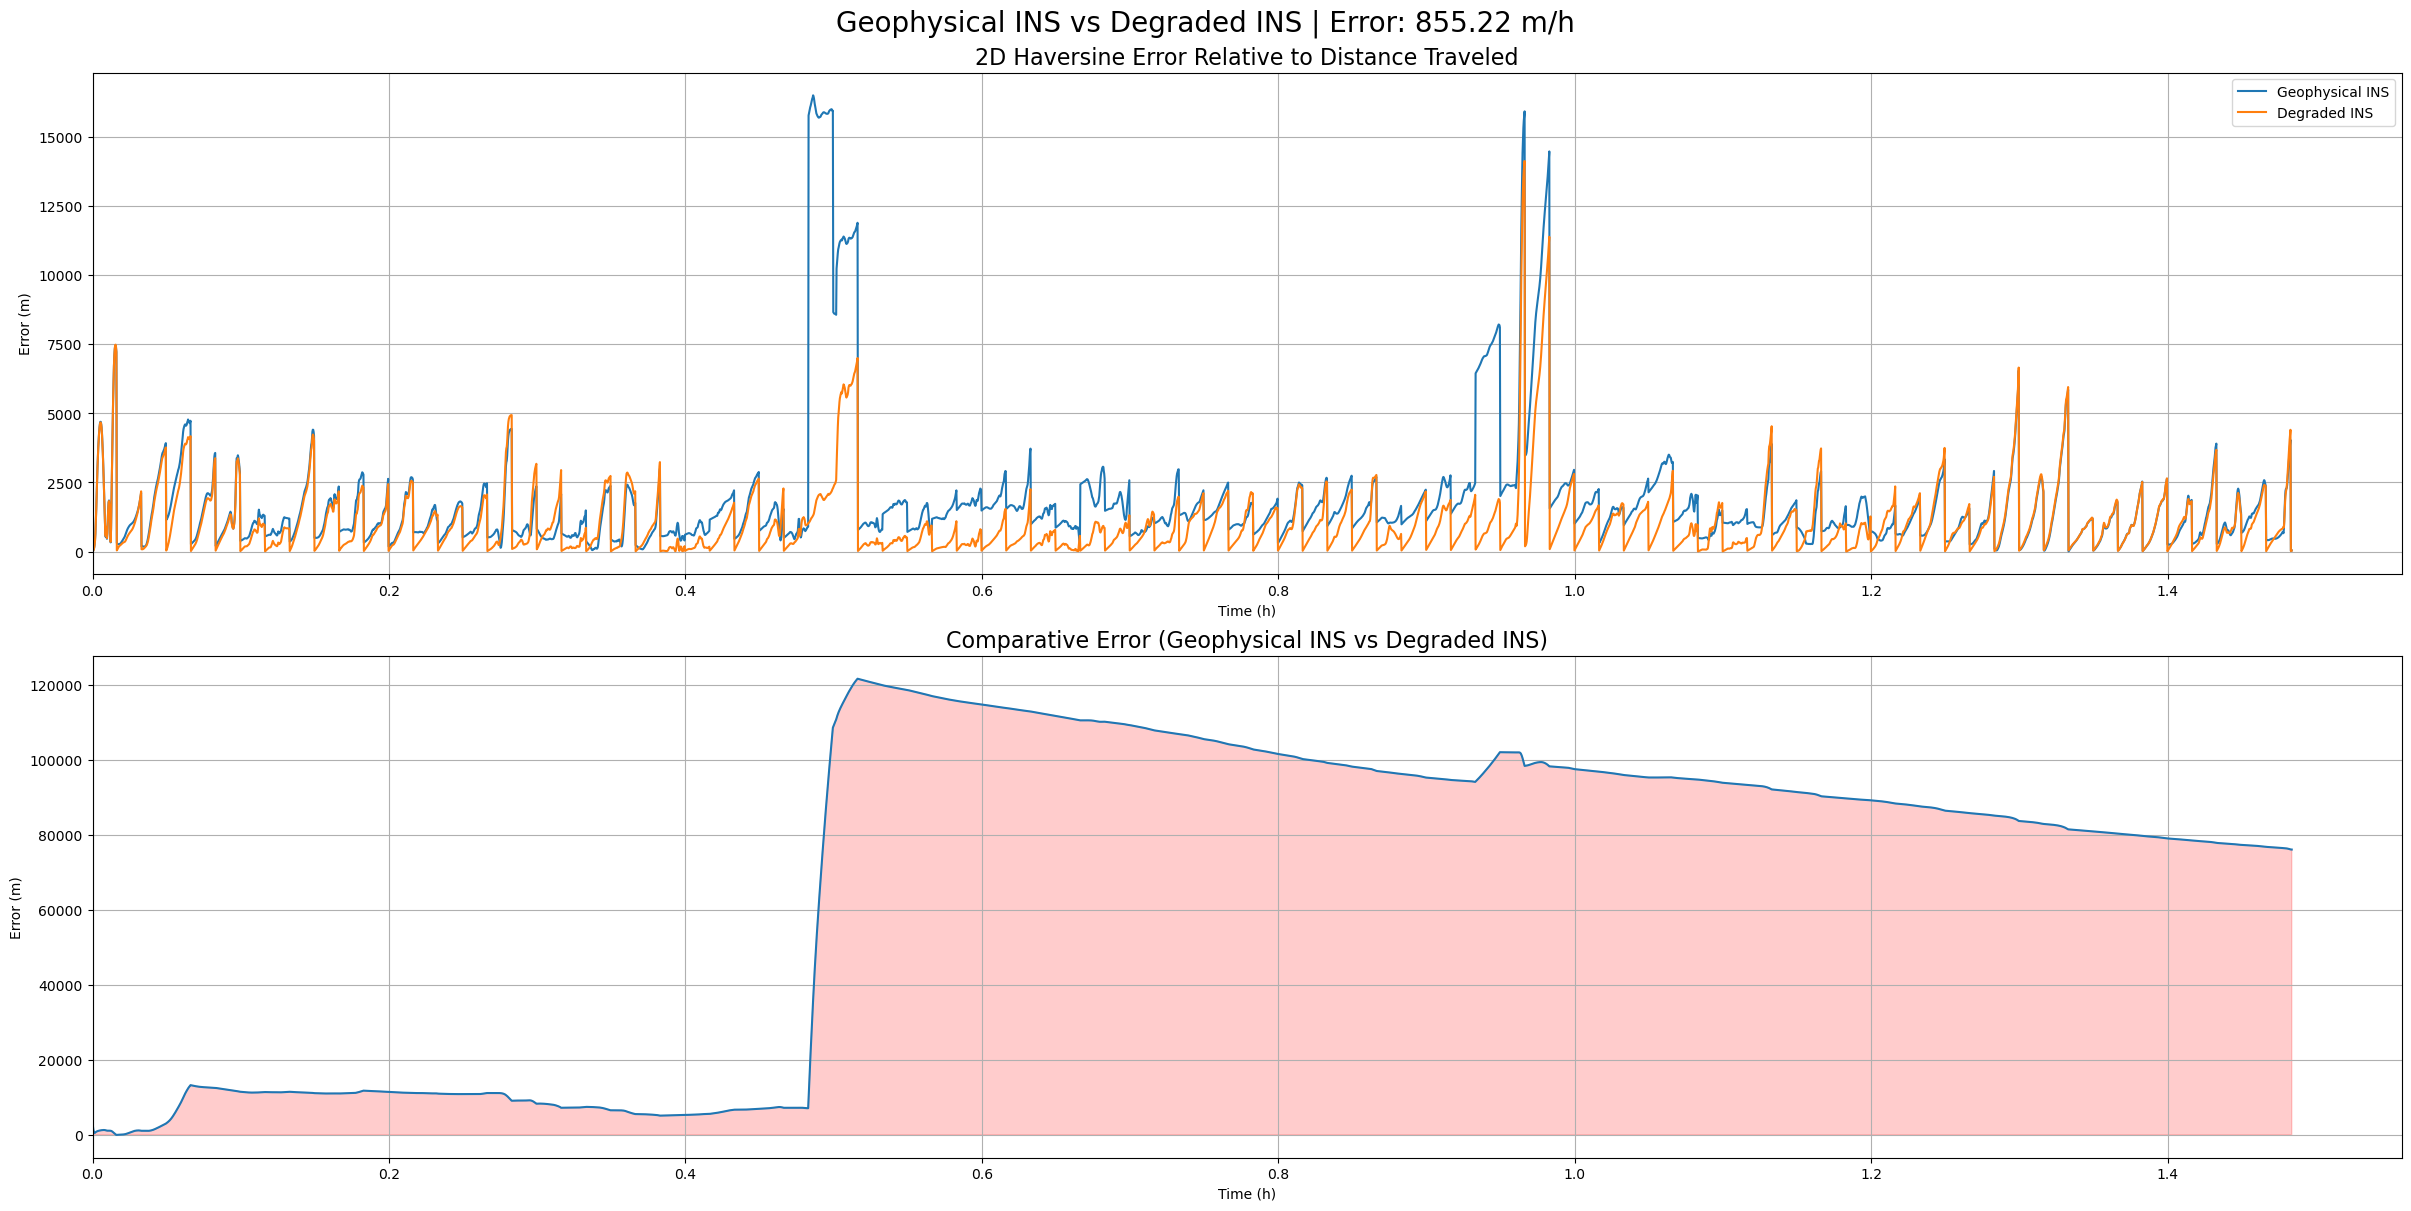

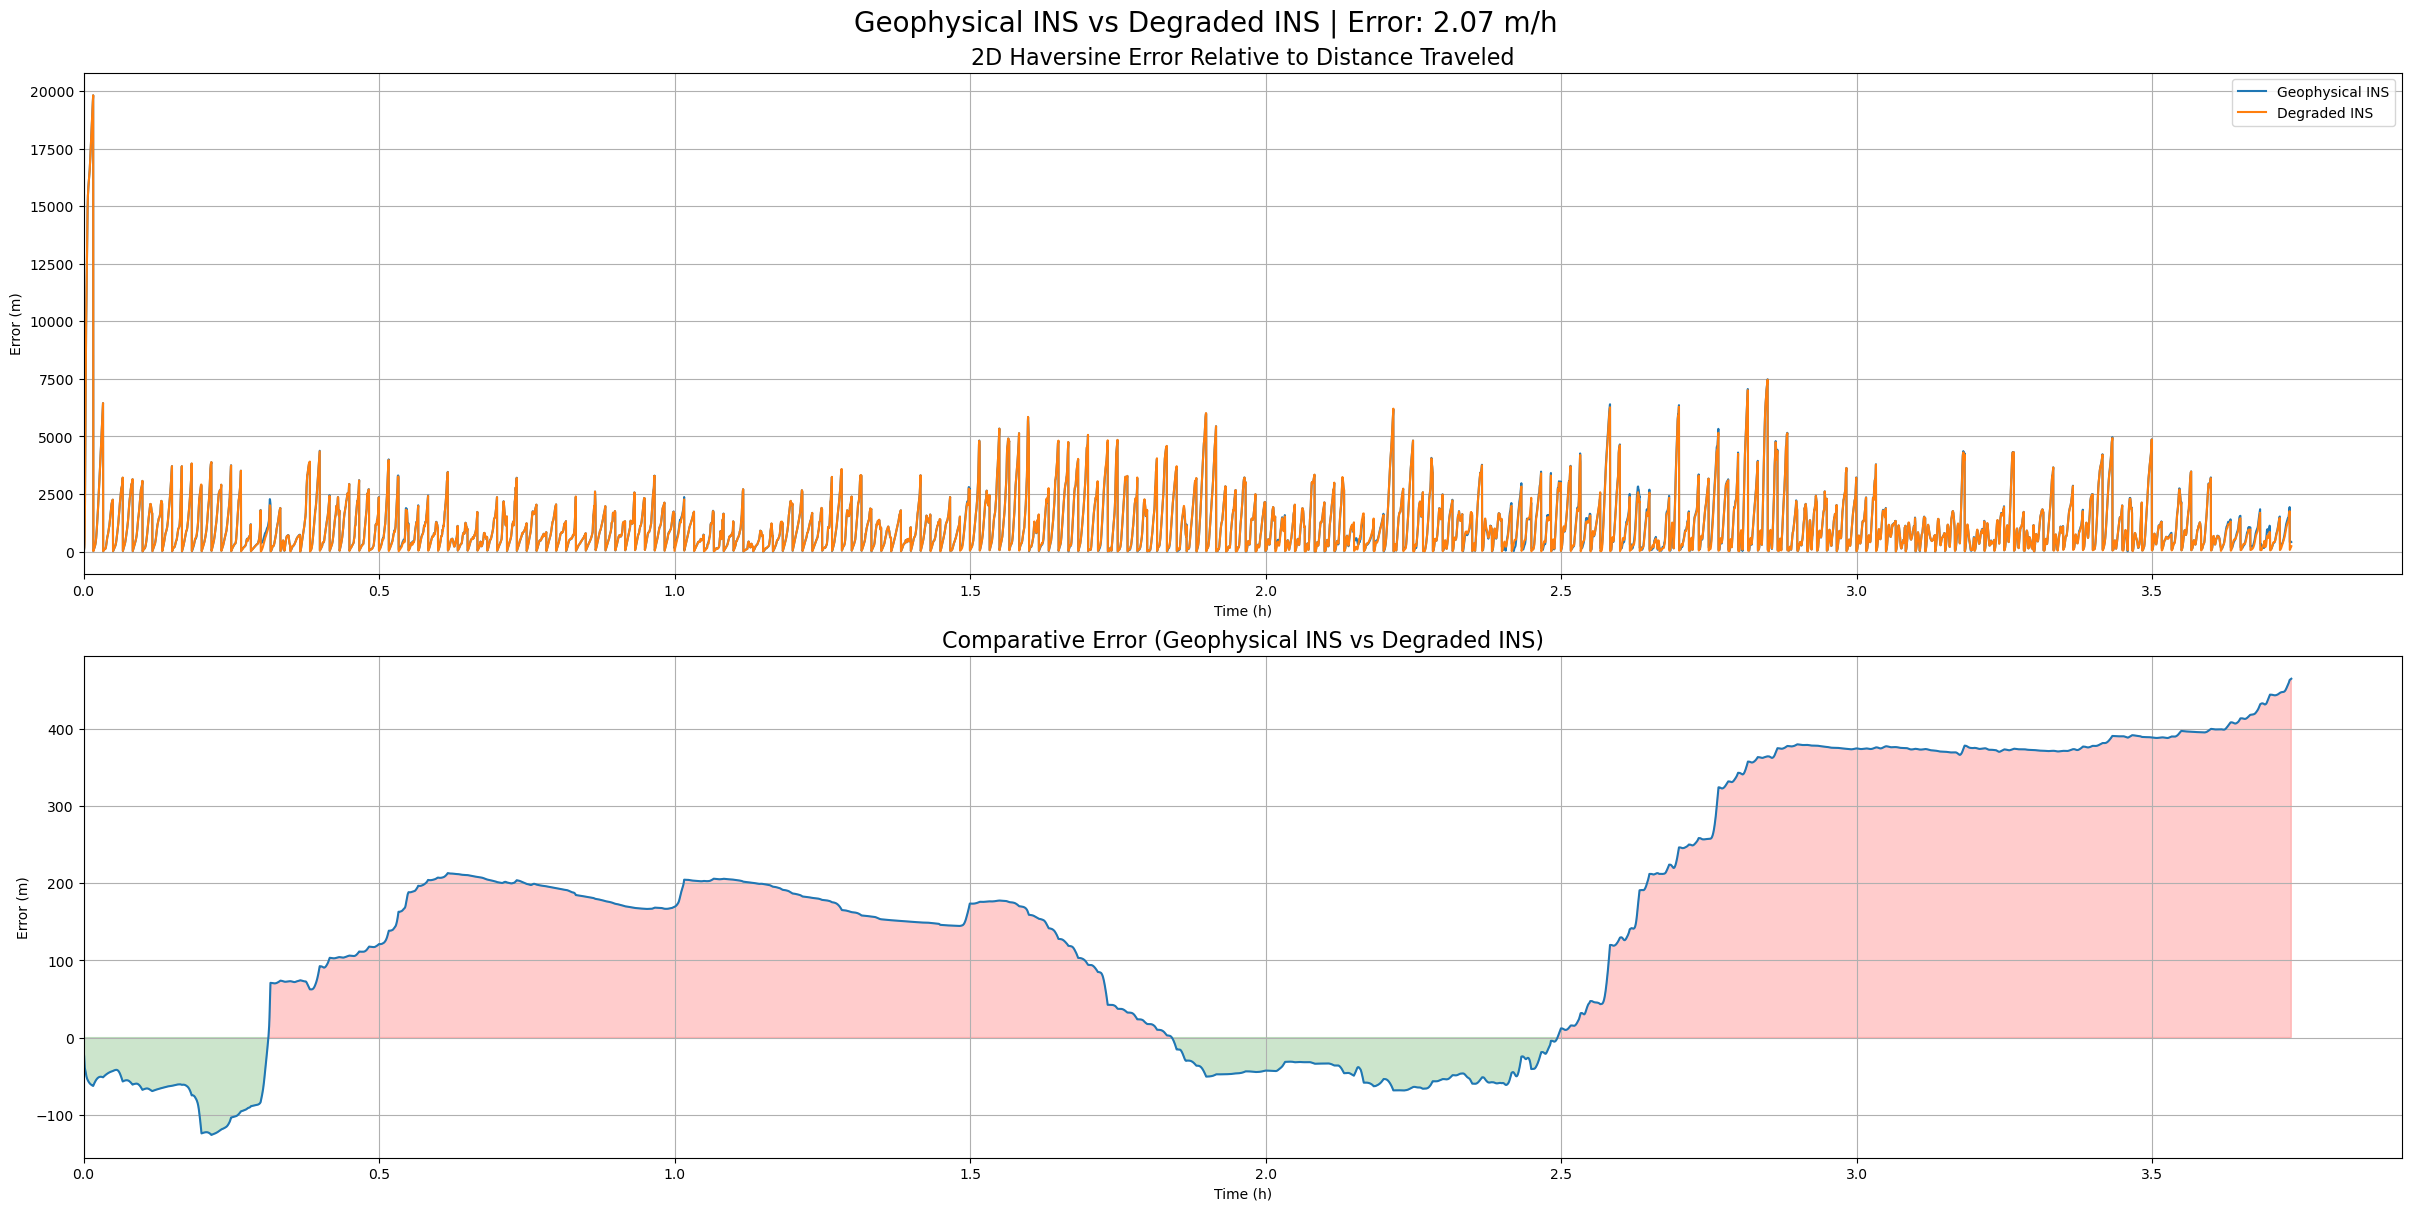

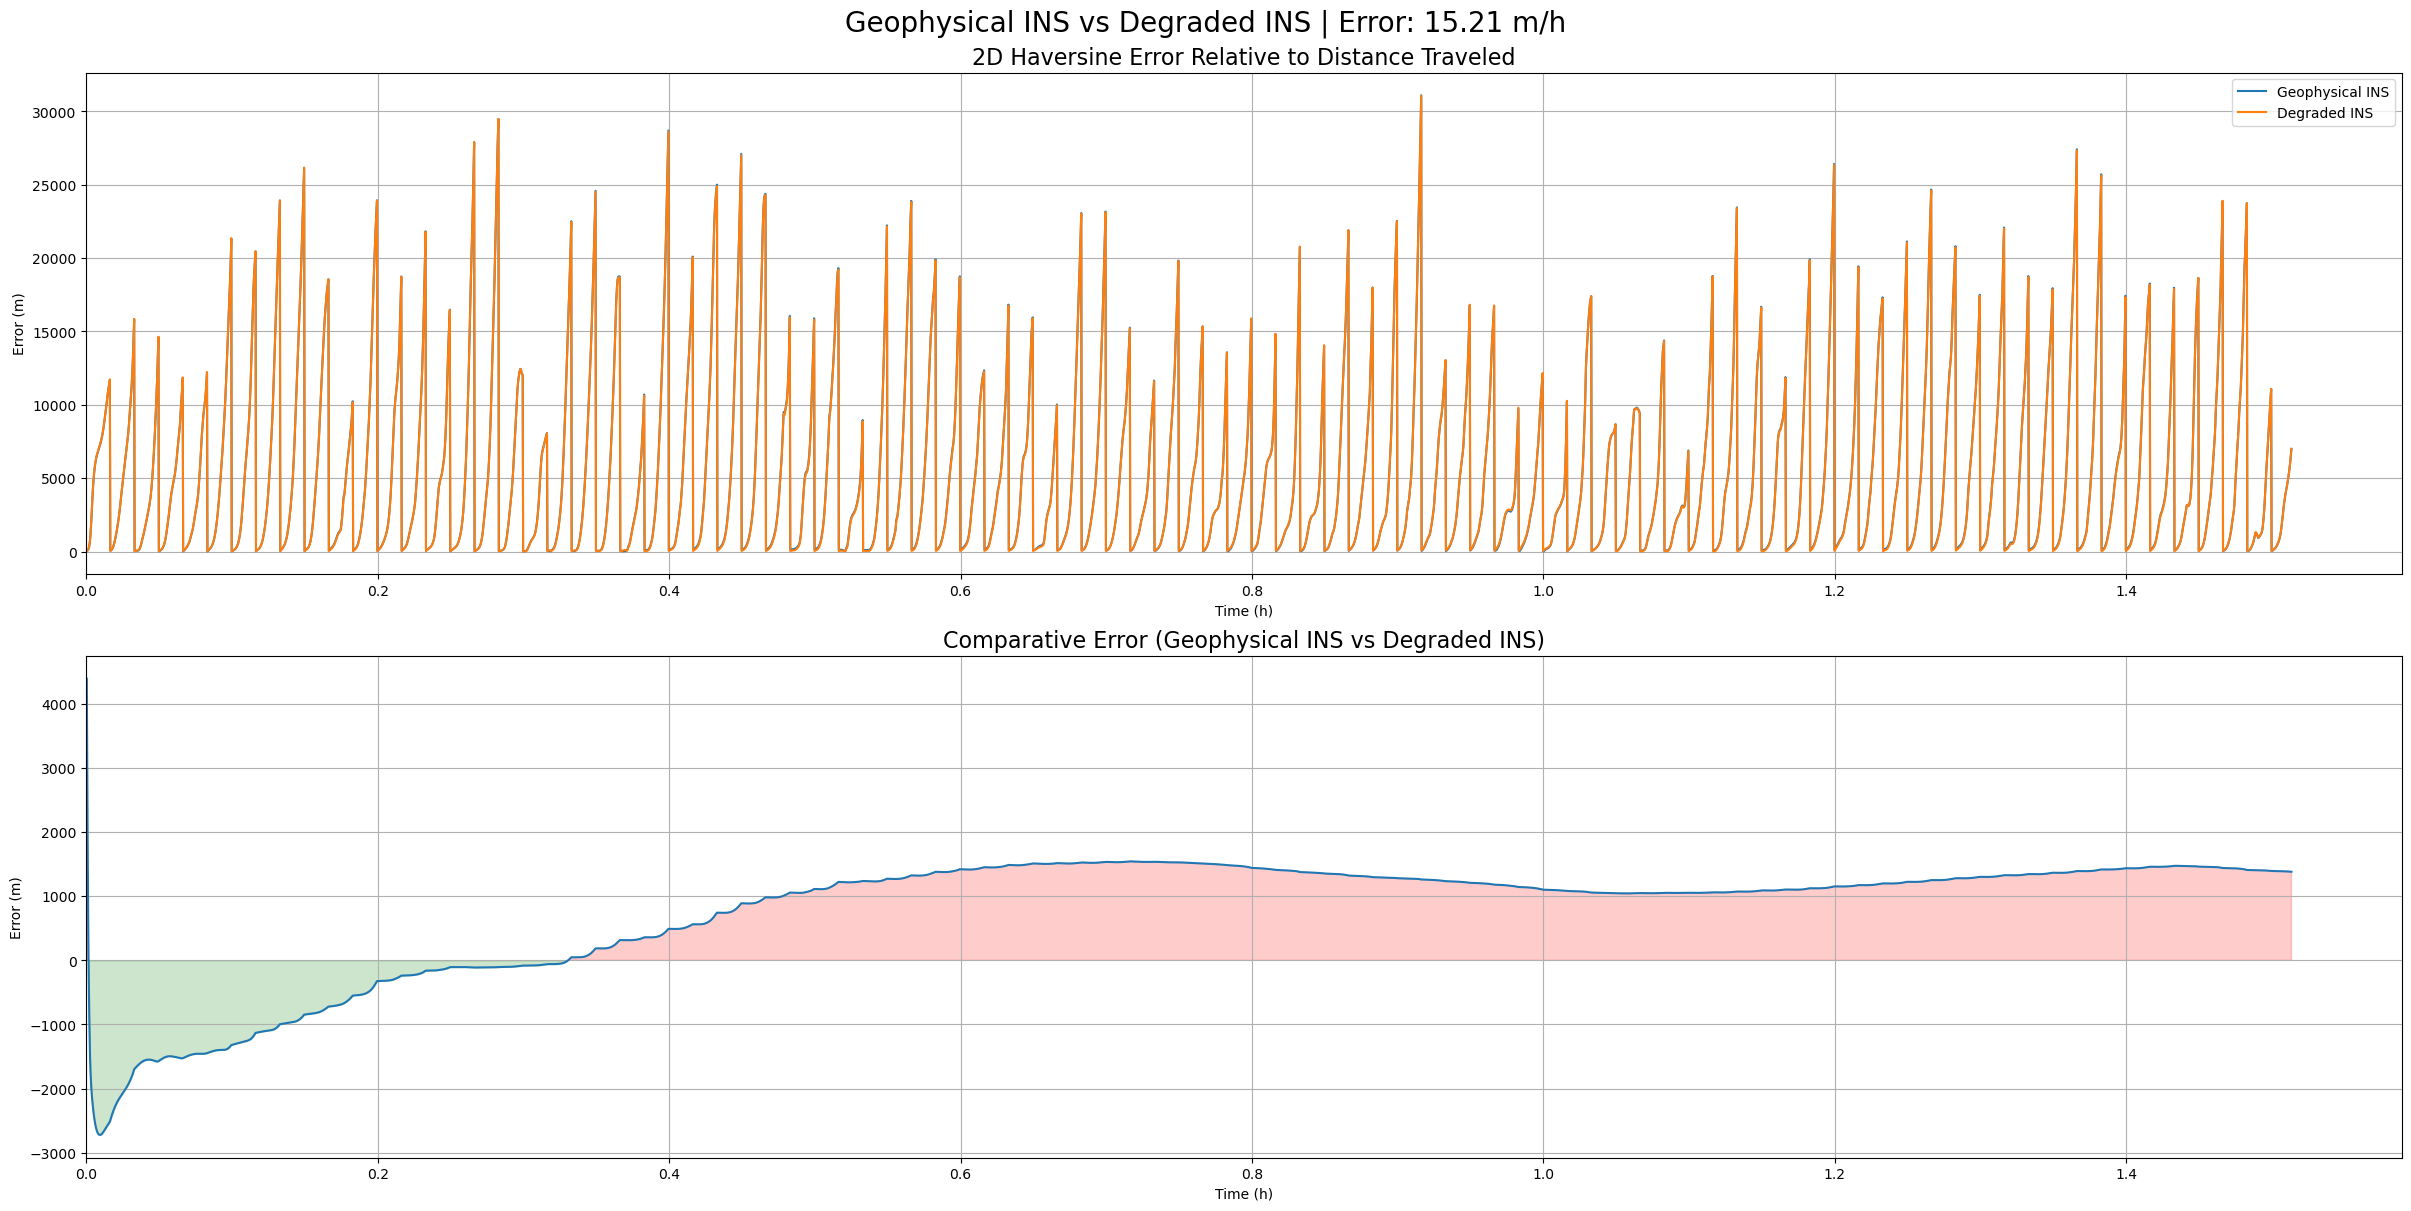

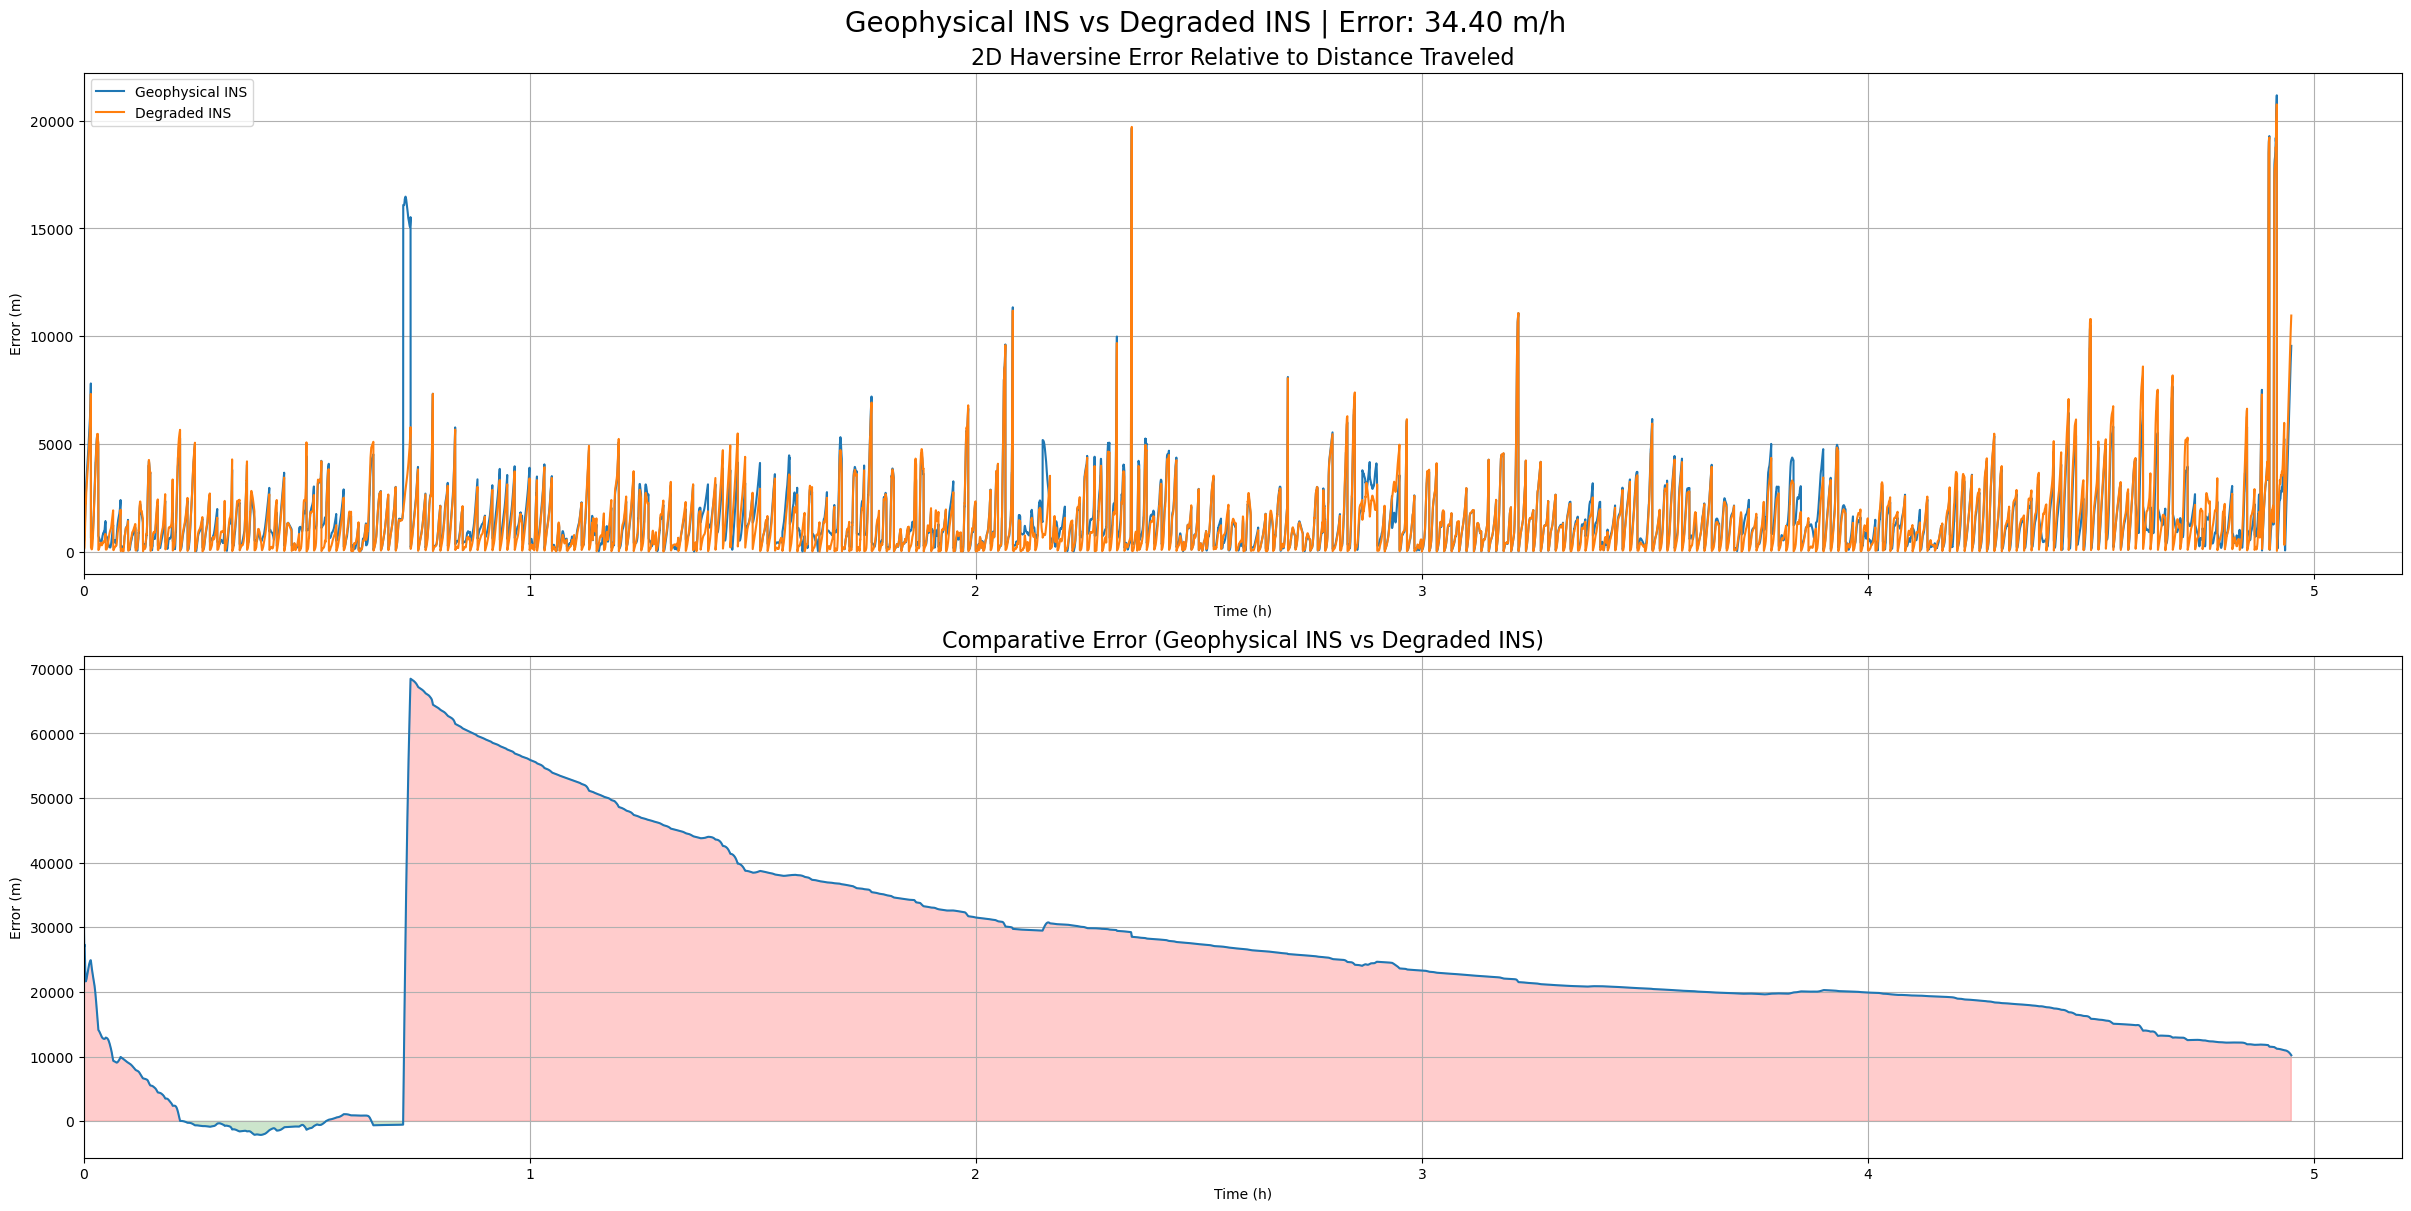

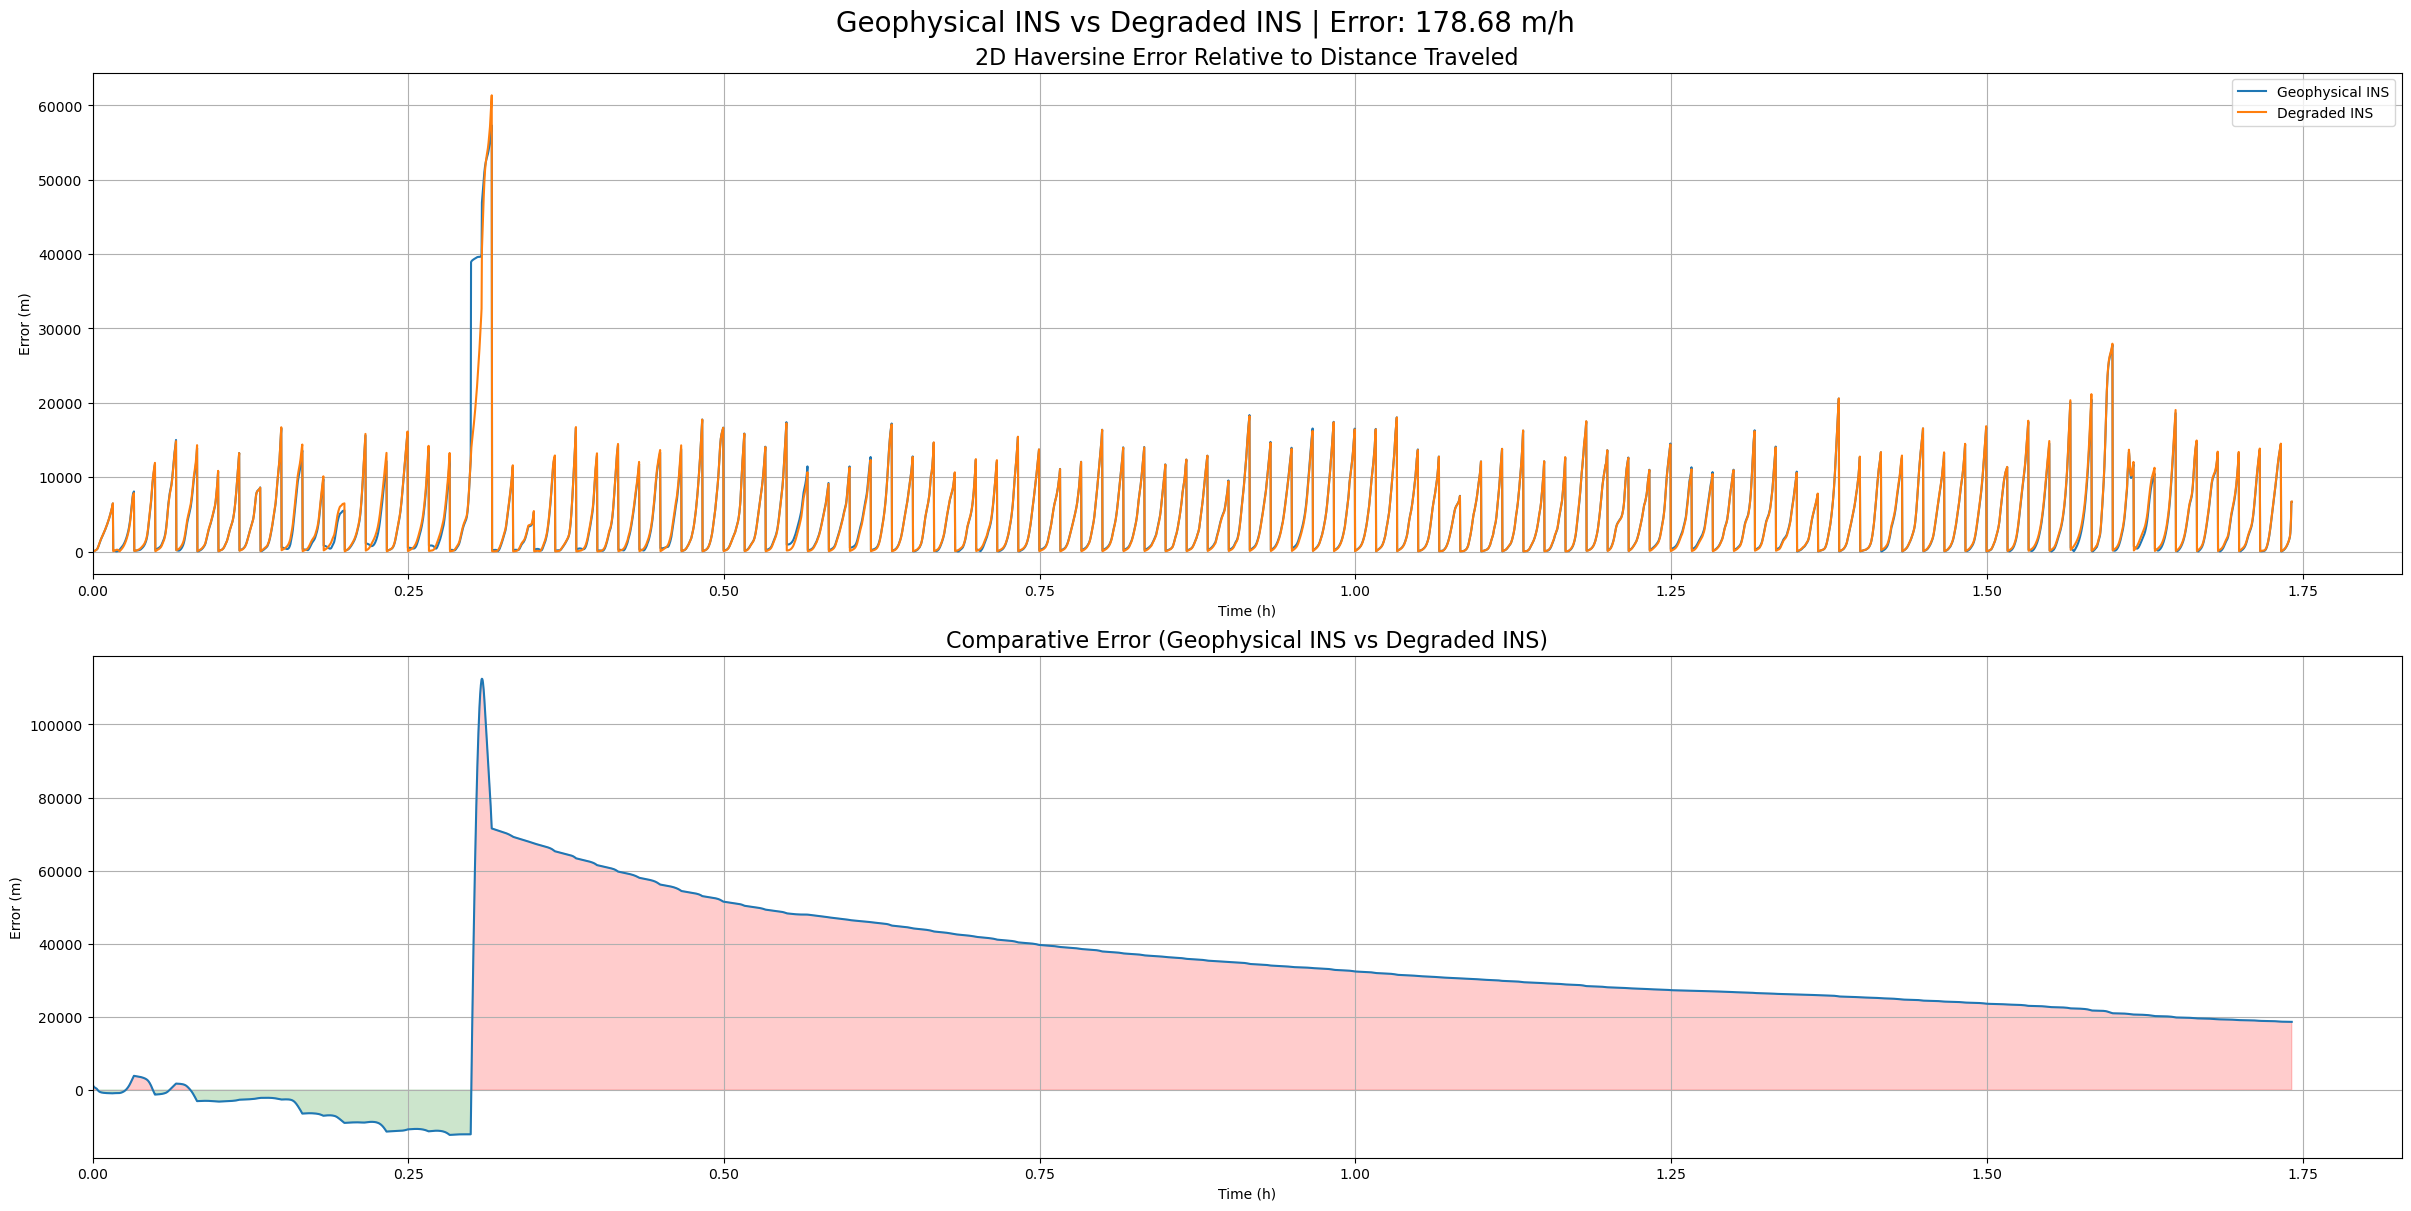

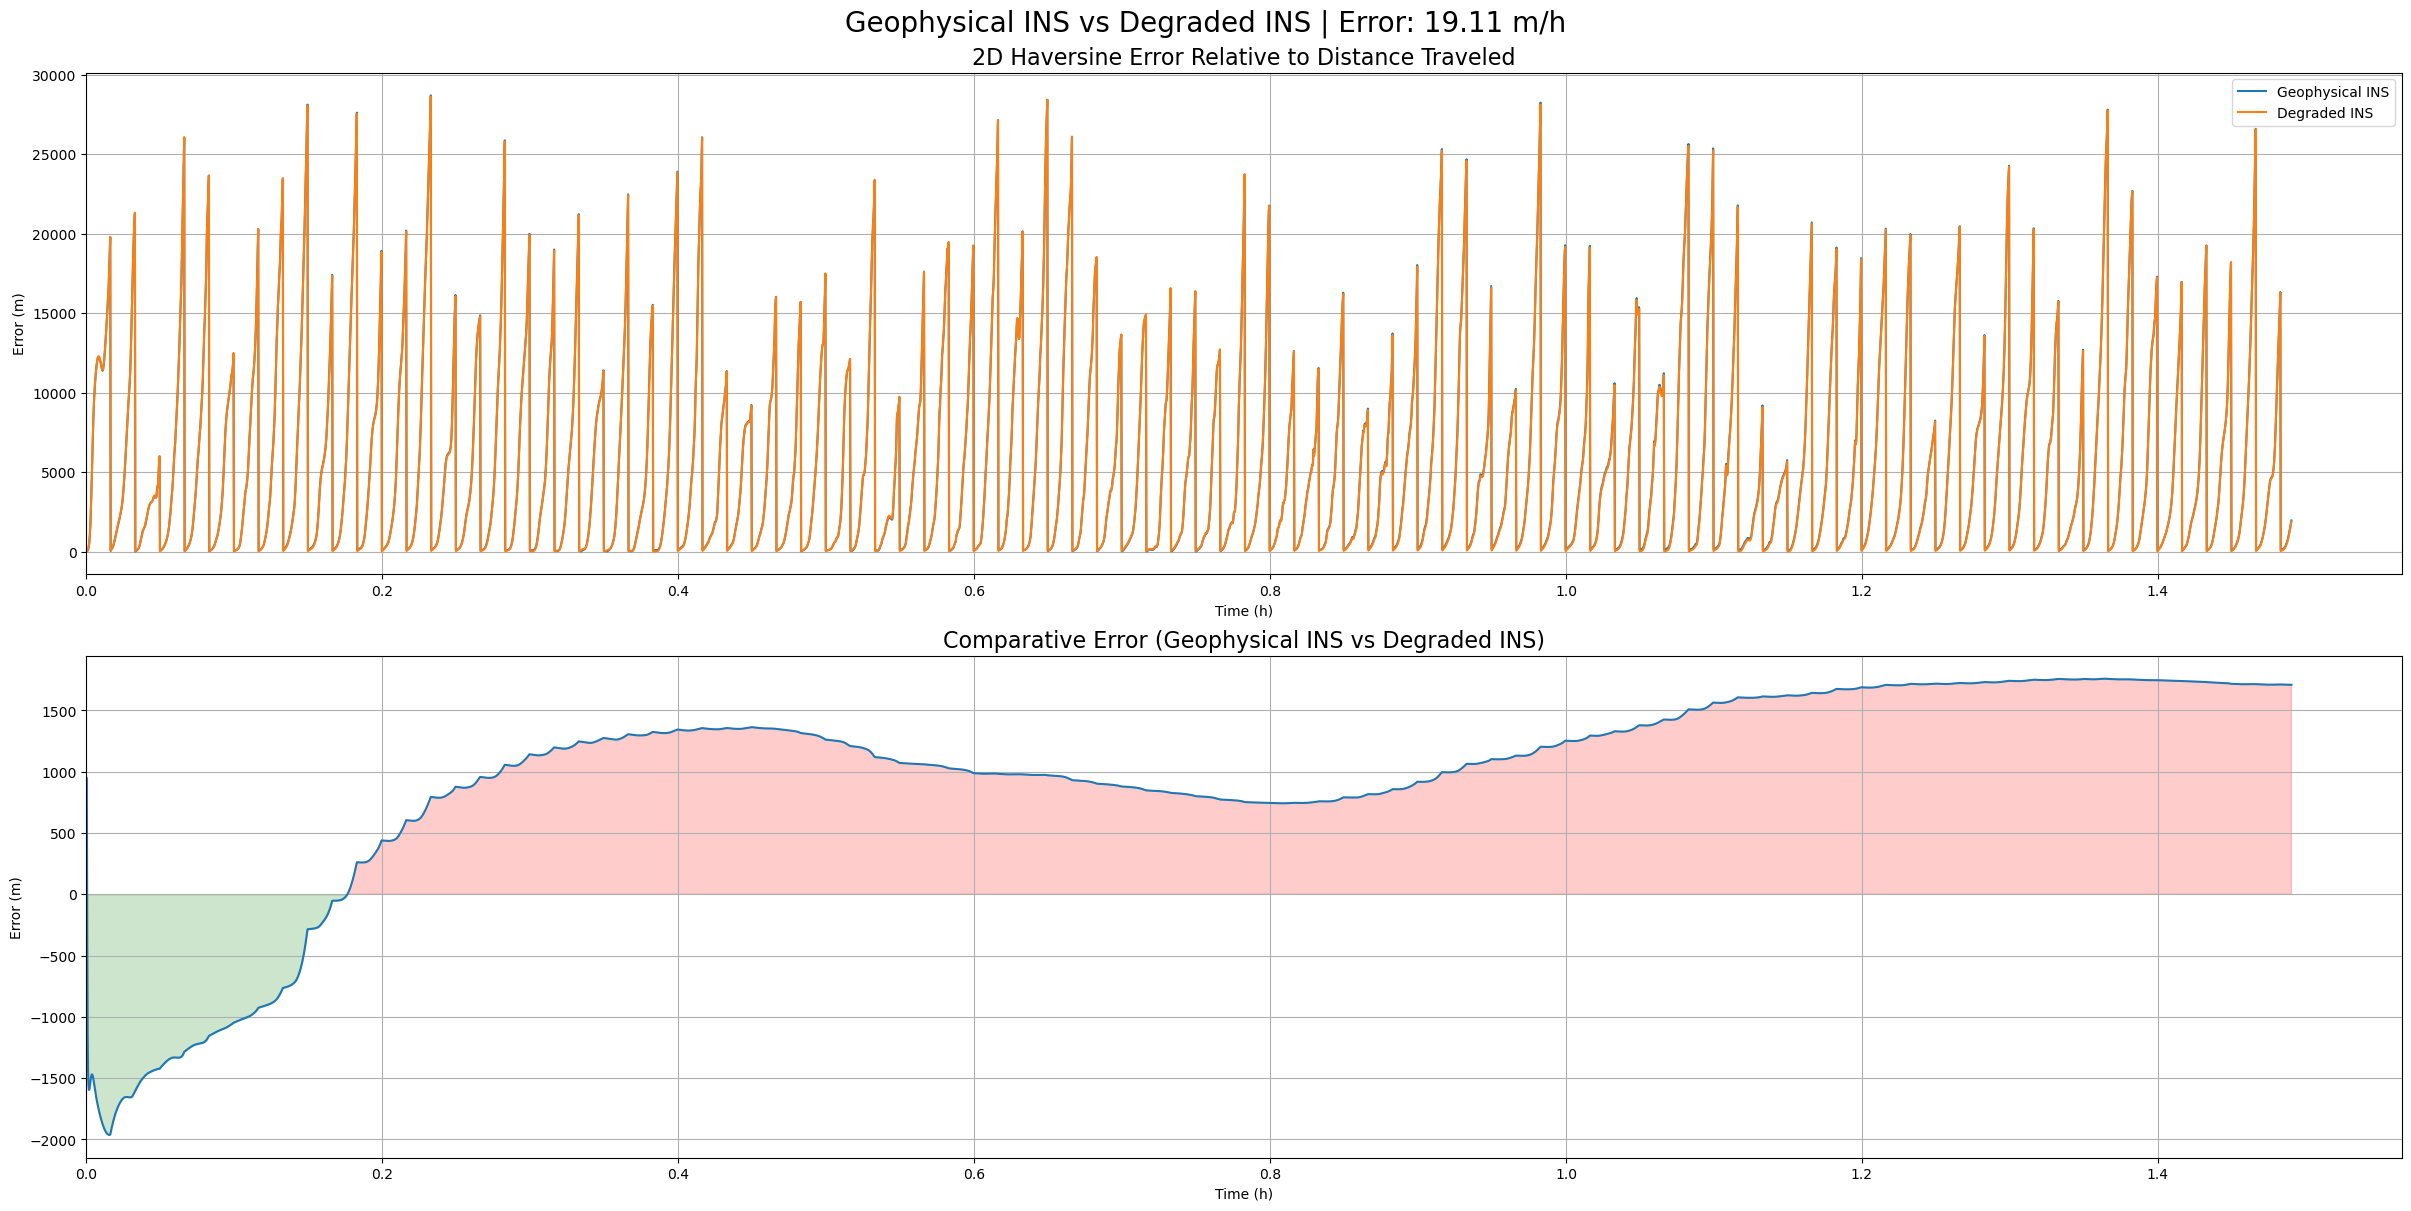

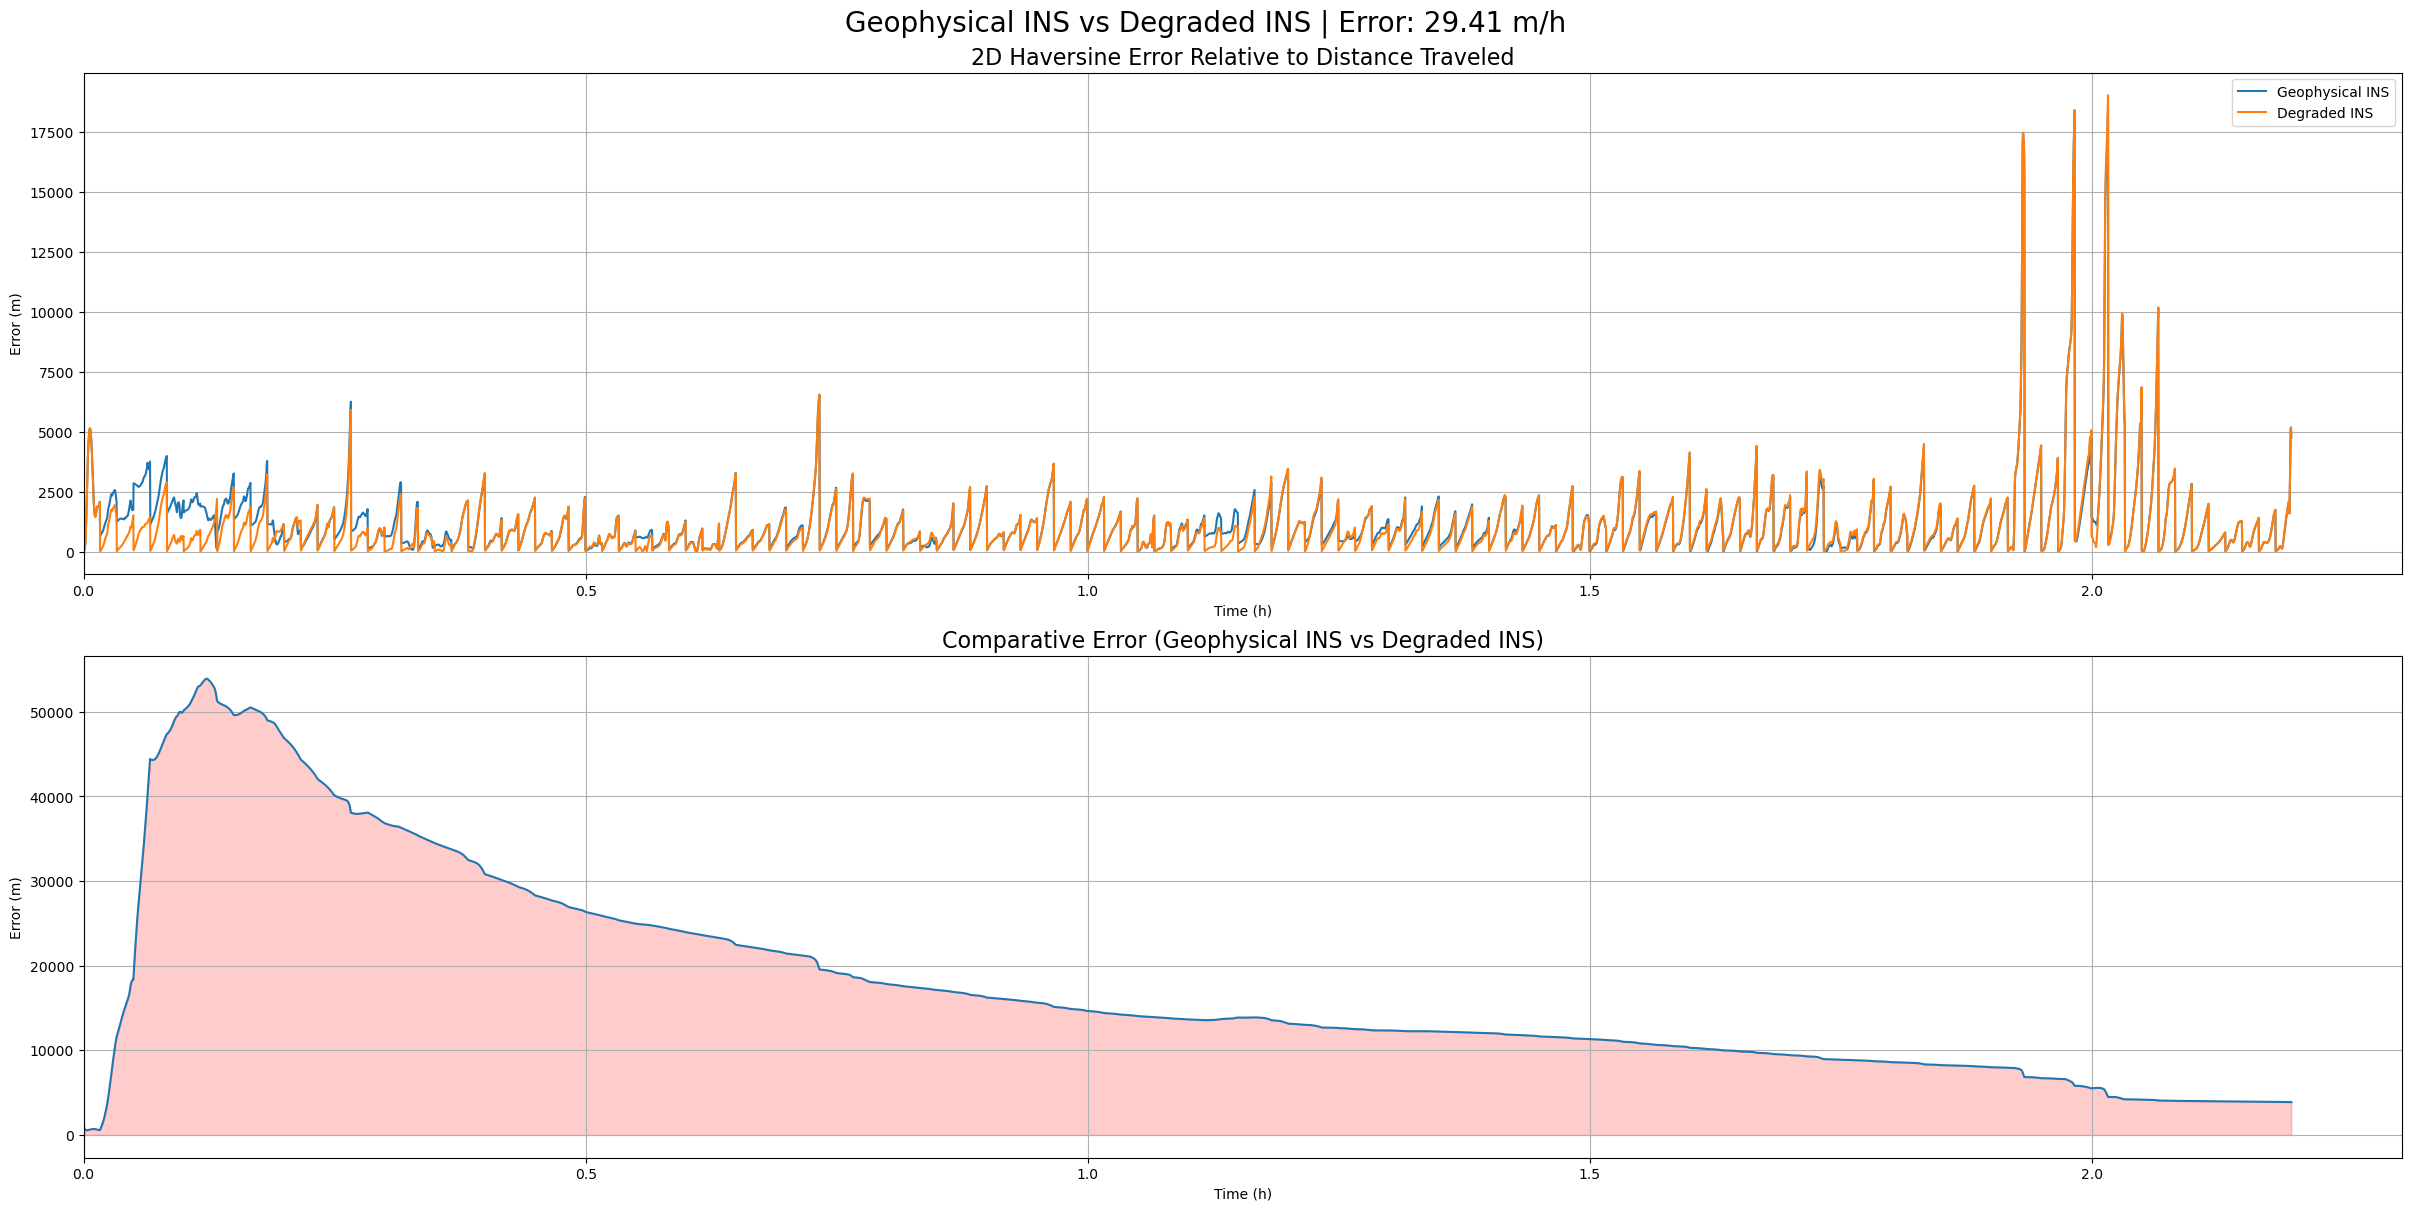

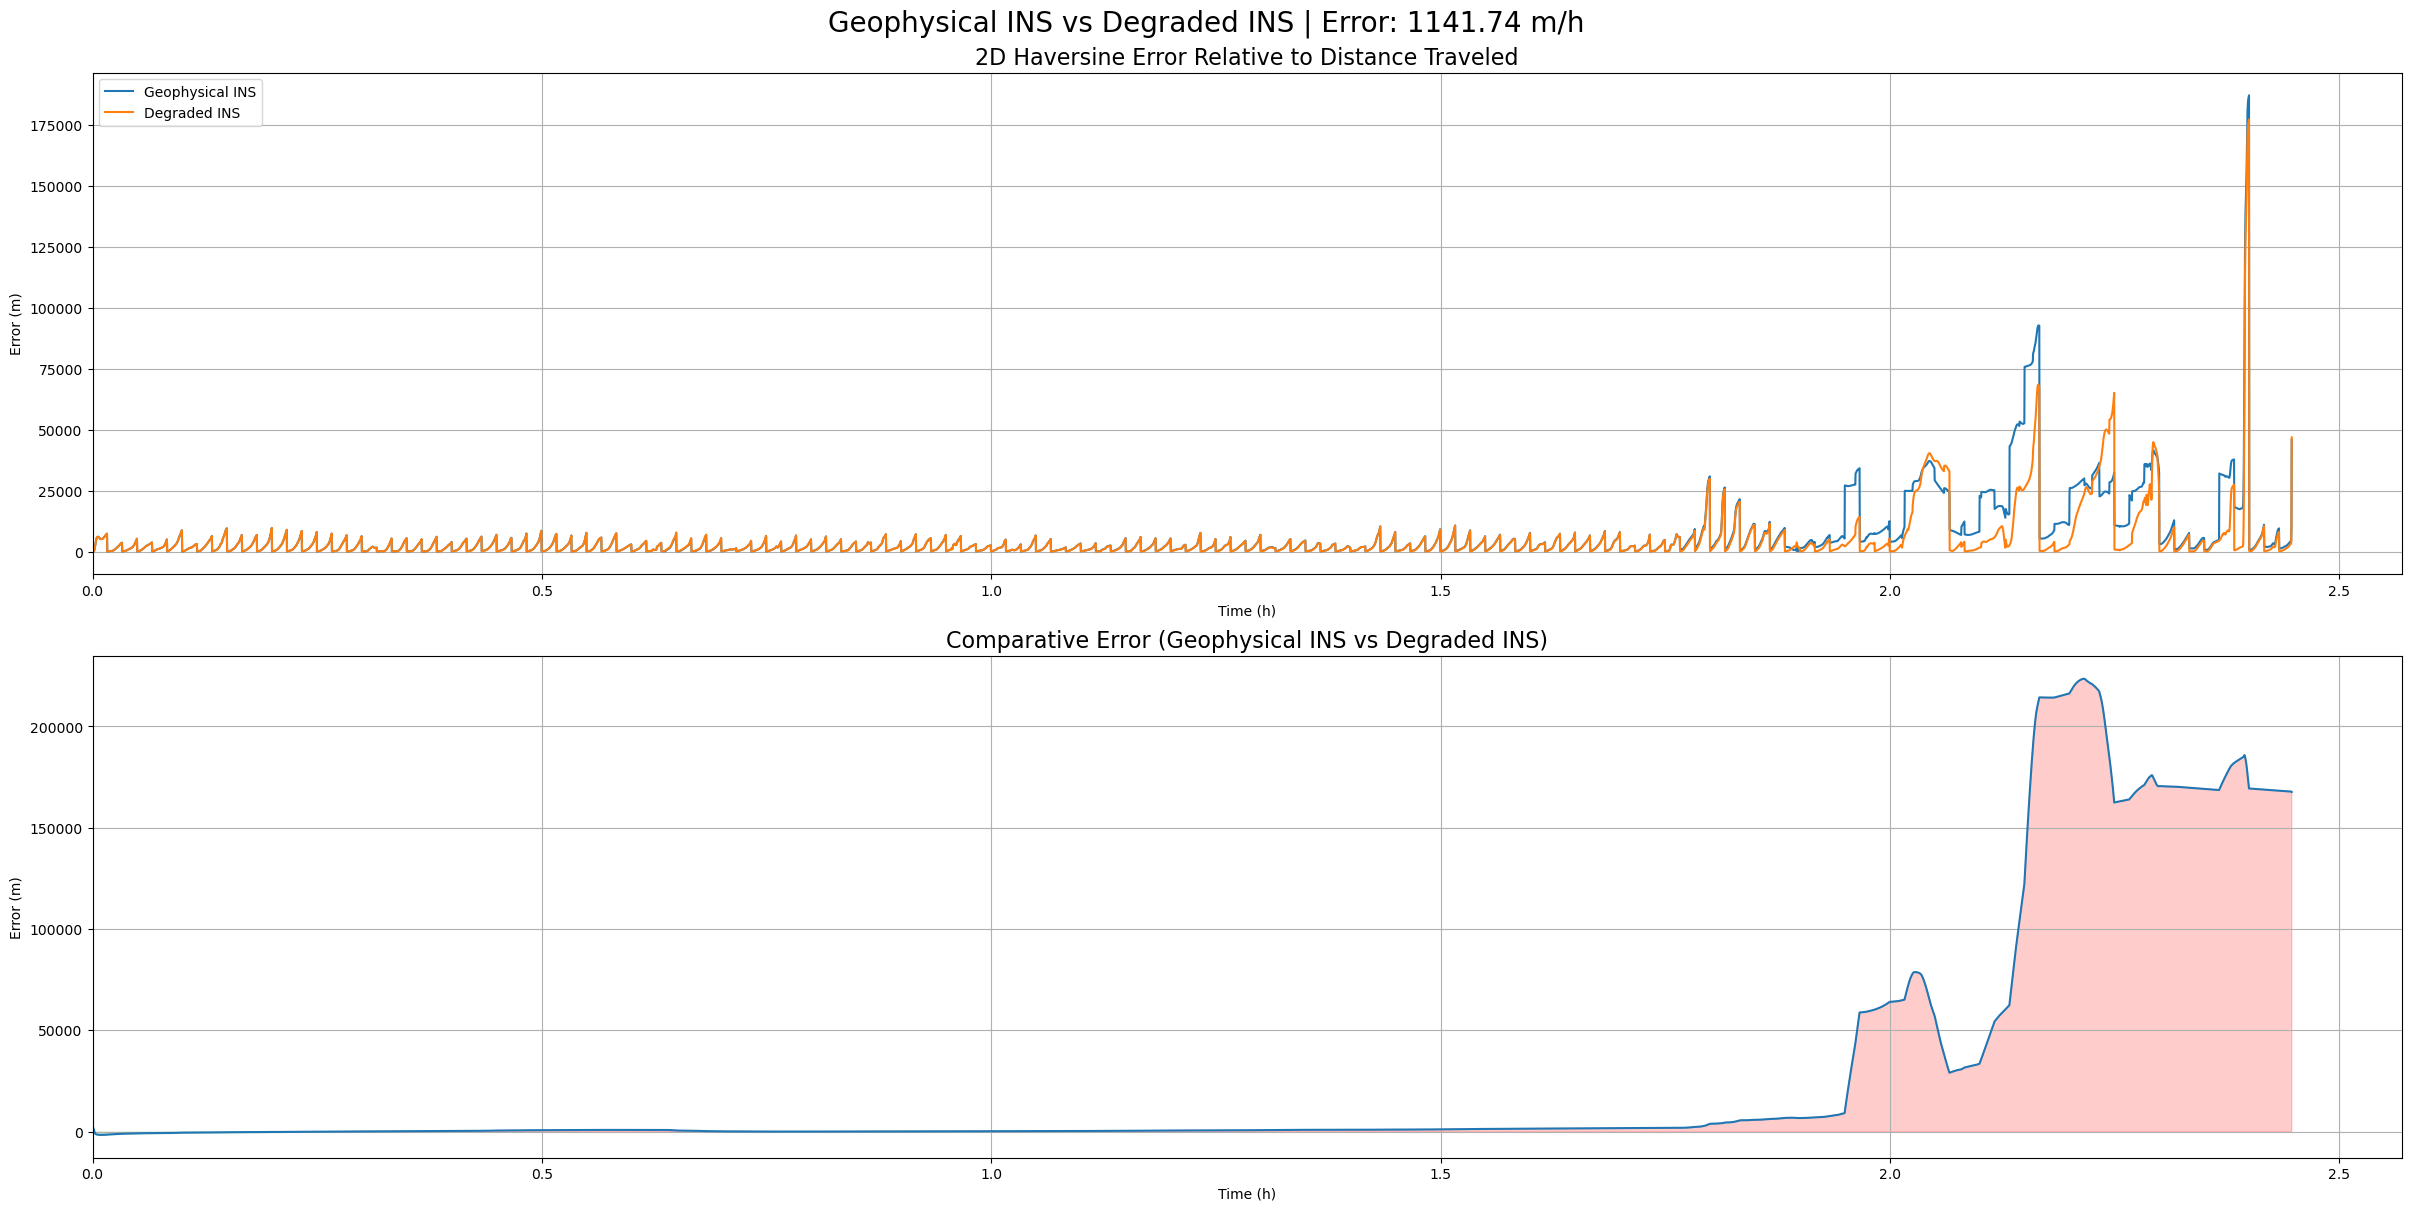

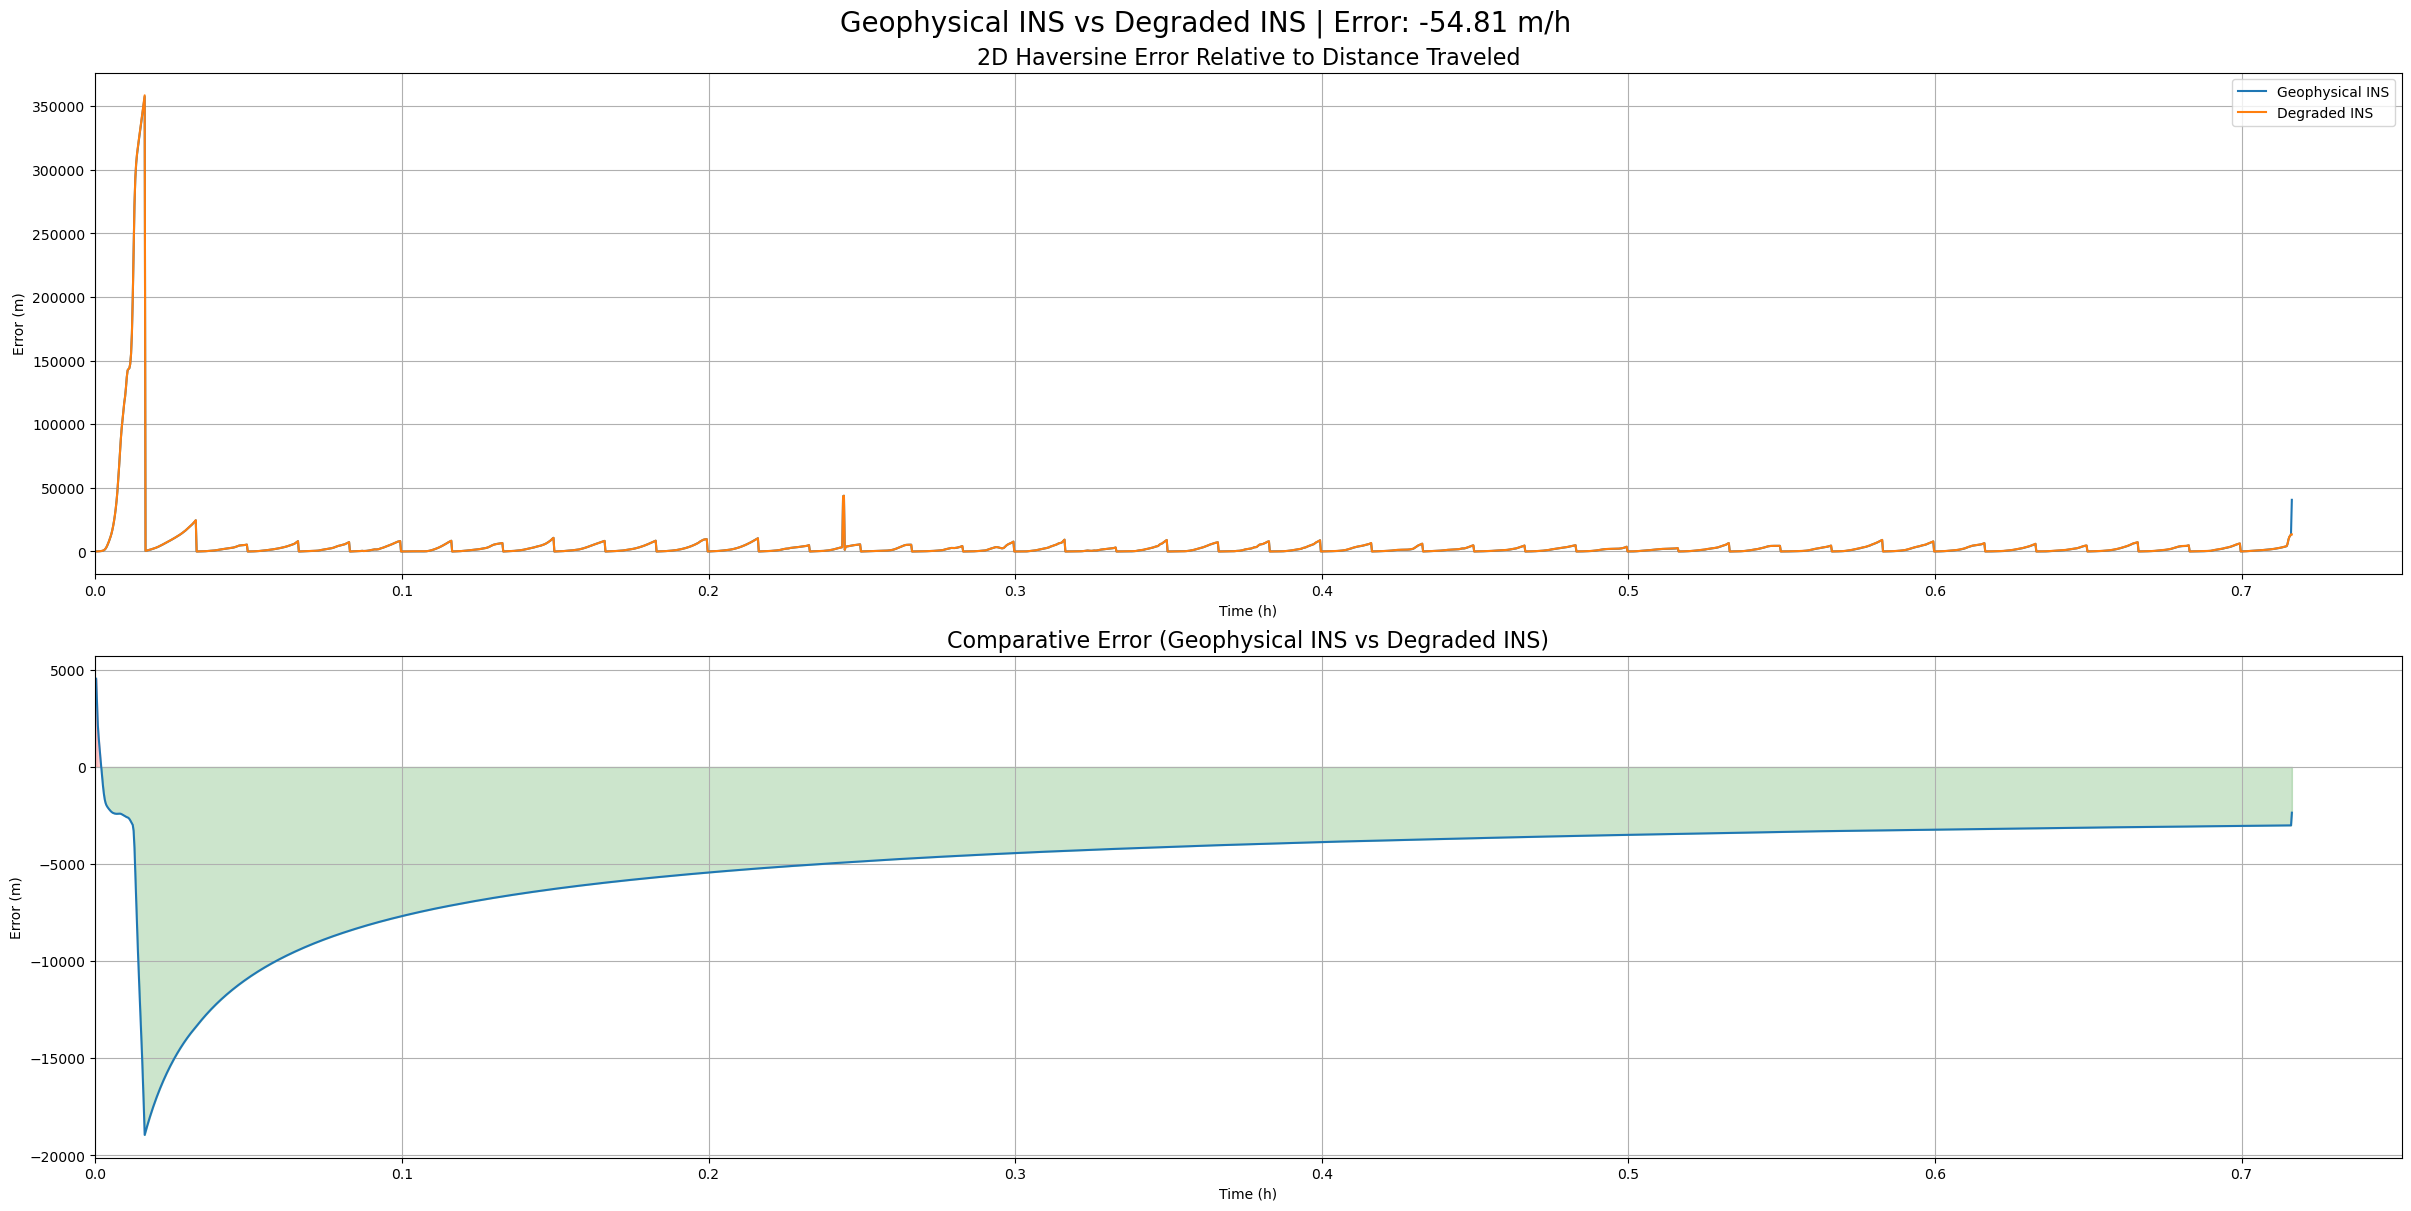

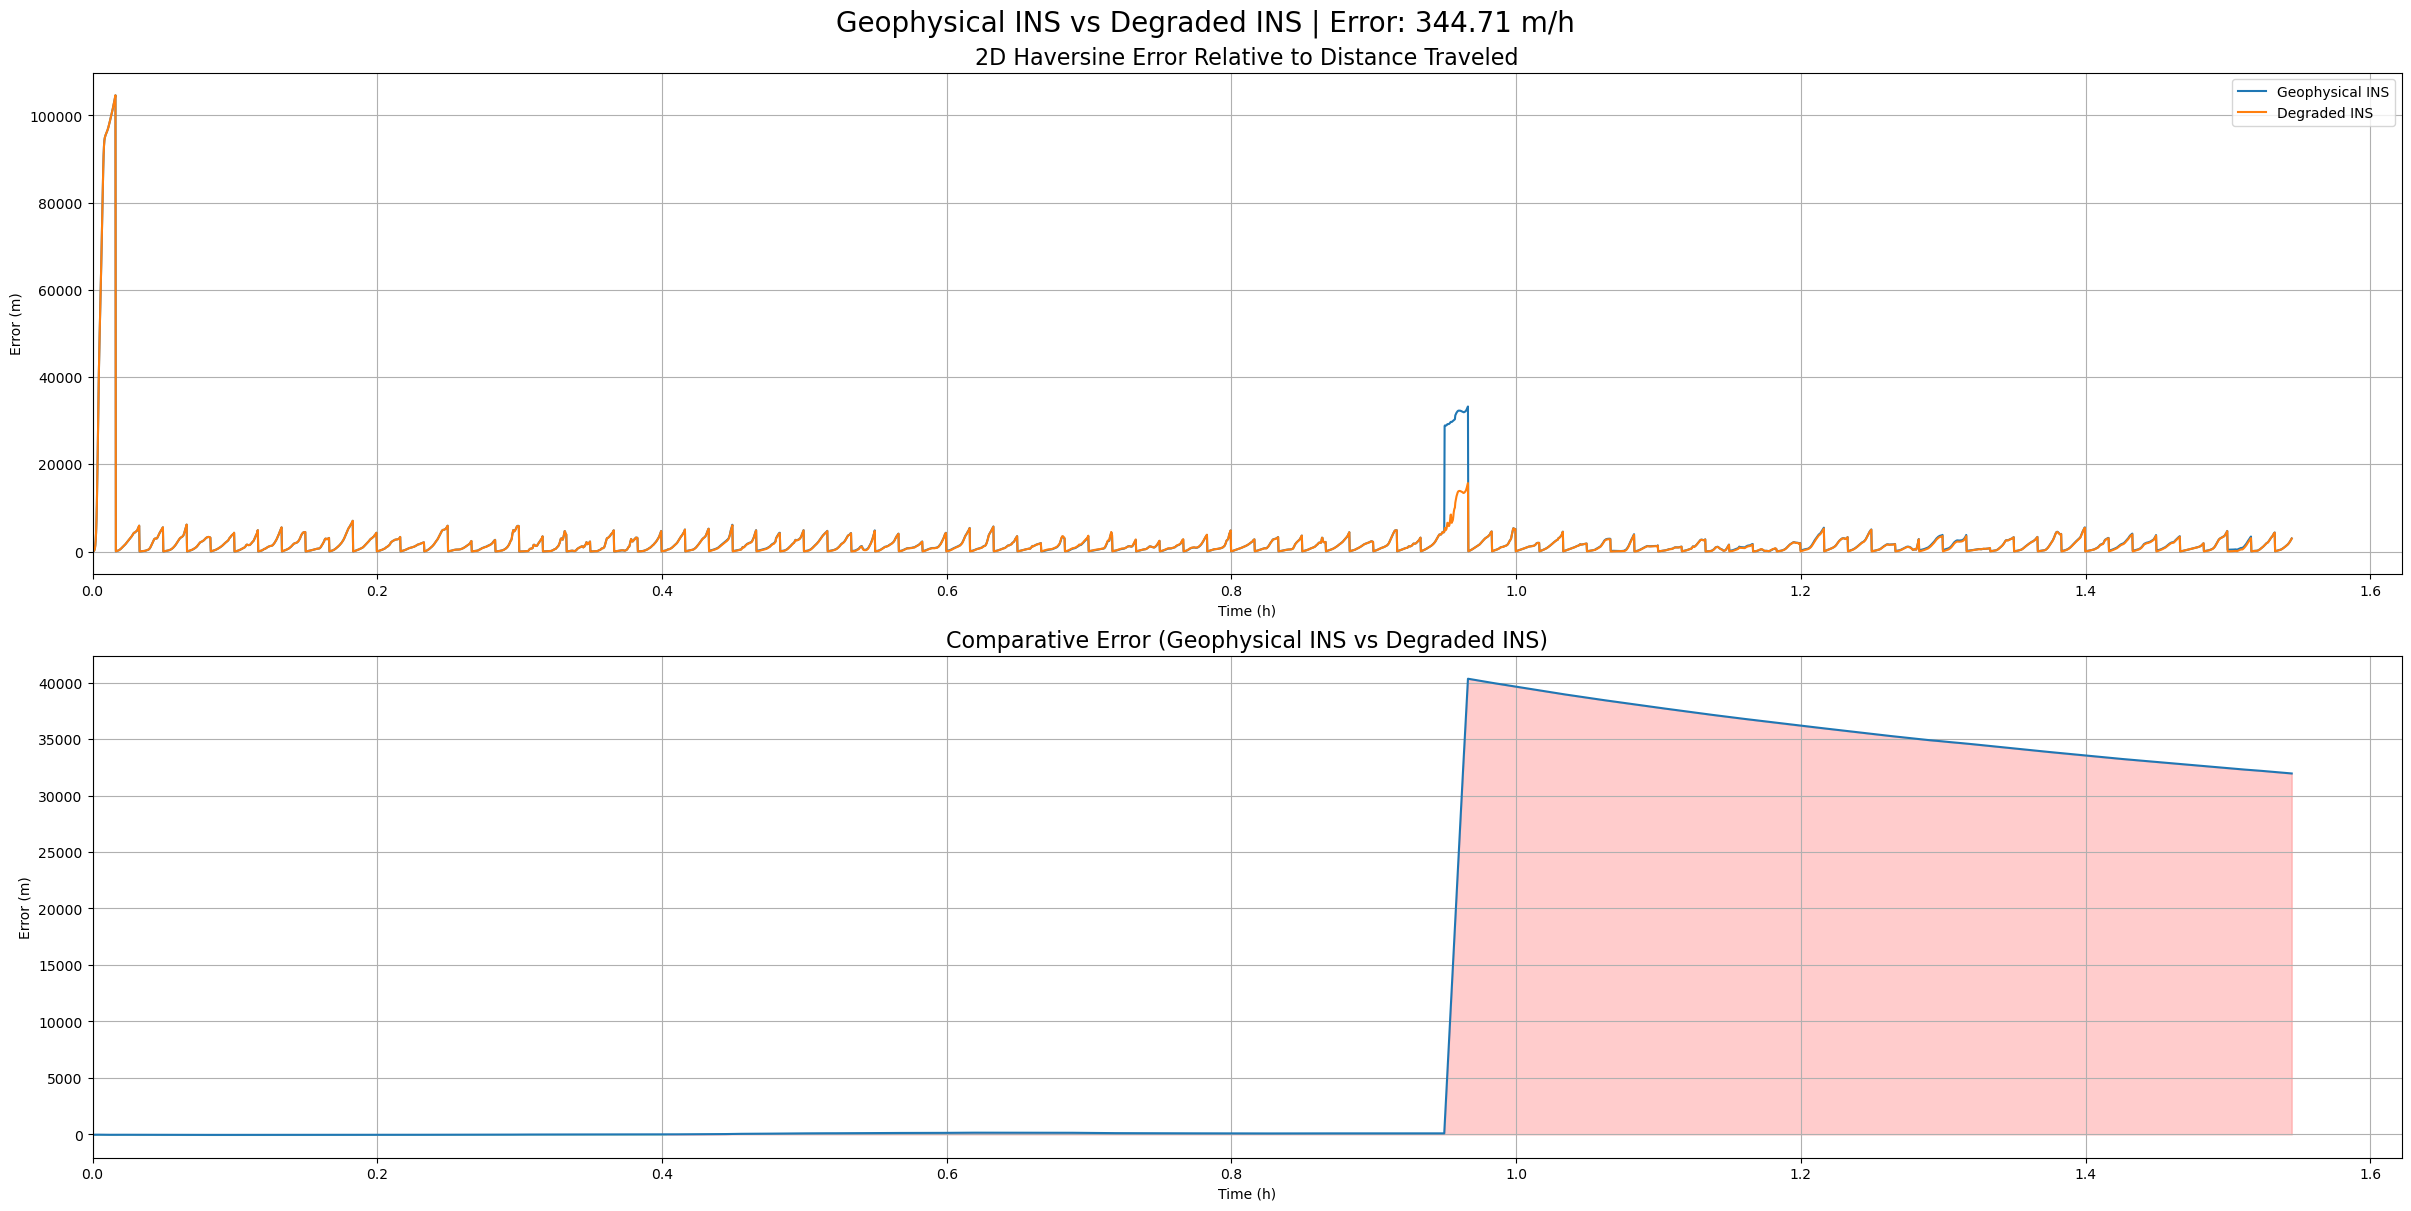

In [40]:
file_list = ROOT.parents[1].joinpath("data", "input").glob("*.csv")

for file in file_list:
    try:
        gps = pd.read_csv(ROOT.parents[1].joinpath("data", "input" ,f"{file}"), index_col=0, parse_dates=True)
        nav = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file.stem}_truth.csv"), index_col=0, parse_dates=True)
        deg = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file.stem}_degraded.csv"), index_col=0, parse_dates=True)
        geo = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file.stem}_geo.csv"), index_col=0, parse_dates=True)
    except FileNotFoundError as e:
        print(f"Error reading output files for {file}: {e}")
        continue
    try:
        distance_traveled = haversine_vector(nav[["latitude", "longitude"]].to_numpy()[:-1, :], 
                                            nav[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS)
        distance_traveled = np.nancumsum(distance_traveled)

        geo_error = haversine_vector(geo[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), 
                                        nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)

        deg_error = haversine_vector(deg[["latitude", "longitude"]].to_numpy(), 
                                        nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)

        nav_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), 
                                        gps[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS)
    except Exception as e:
        print(f"Error calculating haversine distances for {file}: {e}")
        continue

    distance_traveled = np.insert(distance_traveled, 0, 0)
    geo_cum_error = np.cumsum(geo_error) # / distance_traveled
    deg_cum_error = np.cumsum(deg_error) # / distance_traveled
    time = (nav.index - nav.index[0]).total_seconds() / 3600

    root_mean_geo_cum_error = np.sqrt(np.cumsum(geo_error**2) / time) # / distance_traveled
    root_mean_deg_cum_error = np.sqrt(np.cumsum(deg_error**2) / time) # / distance_traveled

    err = root_mean_geo_cum_error - root_mean_deg_cum_error
    
    fig, ax = plt.subplots(2, 1, figsize=(24, 12), layout="constrained")
    ax[0].plot(time, geo_error, label="Geophysical INS")
    ax[0].plot(time, deg_error, label="Degraded INS")
    ax[0].set_xlim(left=0)
    #ax[0].set_ylim((0, 250))
    ax[0].set_xlabel('Time (h)')
    ax[0].set_ylabel('Error (m)')
    ax[0].set_title('2D Haversine Error Relative to Distance Traveled', fontsize=16)
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(time, err, label="GeoNav")
    ax[1].fill_between(time, err, 0, where=err > 0, alpha=0.2, color="red")
    ax[1].fill_between(time, err, 0, where=err < 0, alpha=0.2, color="green")
    ax[1].set_xlim(left=0)
    #ax[1].set_ylim((-2, 2))
    ax[1].set_xlabel('Time (h)')
    ax[1].set_ylabel('Error (m)')
    ax[1].set_title('Comparative Error (Geophysical INS vs Degraded INS)', fontsize=16)
    ax[1].grid()

    geo_error_total = np.sqrt(np.mean(geo_error**2)) / time[-1]
    deg_error_total = np.sqrt(np.mean(deg_error**2)) / time[-1]

    fig.suptitle(f"Geophysical INS vs Degraded INS | Error: {geo_error_total - deg_error_total:.2f} m/h", fontsize=20)
    # fig.tight_layout(rect=(0, 0.03, 1, 0.95))
    print(f"Writing image to {ROOT.parents[1].joinpath('images', f'{file.stem}.png')}")
    plt.savefig(ROOT.joinpath("out", geo_type, "images", f"{file.stem}.png"), dpi=300)

In [ ]:
file_list = ROOT.parents[1].joinpath("data", "input").glob("*.csv")

In [ ]:
file = "2025-07-31_23-36-03"

In [ ]:
gps = pd.read_csv(ROOT.parents[1].joinpath("data", "input" ,f"{file}.csv"), index_col=0, parse_dates=True)
nav = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file}_truth.csv"), index_col=0, parse_dates=True)
deg = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file}_degraded.csv"), index_col=0, parse_dates=True)
geo = pd.read_csv(ROOT.joinpath("out", geo_type, f"{file}_geo.csv"), index_col=0, parse_dates=True)

In [ ]:
distance_traveled = haversine_vector(nav[["latitude", "longitude"]].to_numpy()[:-1, :], 
                                          nav[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS)
distance_traveled = np.hstack(([0], distance_traveled))
distance_traveled = np.nancumsum(distance_traveled)

geo_error = haversine_vector(geo[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), 
                                nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)

deg_error = haversine_vector(deg[["latitude", "longitude"]].to_numpy(), 
                                nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)

nav_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), 
                                gps[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS)

time = (nav.index - nav.index[0]).total_seconds() / 3600


In [ ]:
plt.plot(time, root_mean_geo_cum_error - root_mean_deg_cum_error, label="Geophysical INS")
plt.fill_between(time, root_mean_geo_cum_error - root_mean_deg_cum_error, 0, where=(root_mean_geo_cum_error - root_mean_deg_cum_error) > 0, alpha=0.2, color="red")
plt.fill_between(time, root_mean_geo_cum_error - root_mean_deg_cum_error, 0, where=(root_mean_geo_cum_error - root_mean_deg_cum_error) < 0, alpha=0.2, color="green")
plt.xlabel('Time (h)')
plt.ylabel('Error (m)')
plt.xlim(left=0)

In [ ]:
# Get RMSE for each error type
geo_rmse = np.sqrt(np.mean(geo_error**2))
deg_rmse = np.sqrt(np.mean(deg_error**2))
nav_rmse = np.sqrt(np.mean(nav_error**2))
print(f"Geophysical INS RMSE: {geo_rmse:.2f} m")
print(f"Degraded INS RMSE: {deg_rmse:.2f} m")
print(f"Navigation RMSE: {nav_rmse:.2f} m")

In [ ]:
geo_rmse = np.sqrt(np.mean(geo_error**2))
deg_rmse = np.sqrt(np.mean(deg_error**2))
nav_rmse = np.sqrt(np.mean(nav_error**2))

In [ ]:
distance_traveled.shape

## Particle filter design

So it looks like the integrated UKF model isn't working as well as I'd hoped. I'm going to go back to the earlier style of particle filter based implementation where we use velocities coming out of the INS mechanization as inputs to a particle filter that estimates position errors. We'll assume a particle state vector of $\left[lat, lon, alt, v_n, v_e, v_d, b_{geo}\right]$ where $b_{geo}$ is a bias term for the geophysical measurement. We'll use a simple velocity-only mechanization to propagate particles forward in time. The measurement model will be based on the difference between the measured geophysical value and the value interpolated from the map at the particle's position plus the bias term.

## Particle filter design

So it looks like the integrated UKF model isn't working as well as I'd hoped. I'm going to go back to the earlier style of particle filter based implementation where we use velocities coming out of the INS mechanization as inputs to a particle filter that estimates position errors. We'll assume a particle state vector of $\left[lat, lon, alt, v_n, v_e, v_d, b_{geo}\right]$ where $b_{geo}$ is a bias term for the geophysical measurement. We'll use a simple velocity-only mechanization to propagate particles forward in time. The measurement model will be based on the difference between the measured geophysical value and the value interpolated from the map at the particle's position plus the bias term.

In [ ]:
import xarray as xr
import haversine as hs
import numpy as np
import pandas as pd
from filterpy.monte_carlo import systematic_resample
from tqdm import tqdm

file = "2025-07-08_14-12-53"

def principal_radii(latitude: float | np.ndarray, altitude: float | np.ndarray) -> tuple[float | np.ndarray, float | np.ndarray, float | np.ndarray]:
    """
    Calculate the principal radii of curvature at a given latitude and altitude.
    """
    # WGS-84 ellipsoid parameters
    a = 6378137.0  # semi-major axis in meters (equatorial radius)
    # b = 6356752.3142  # semi-minor axis in meters (polar radius)
    e2 = 0.0818191908425 ** 2 # first eccentricity squared

    lat_rad = np.radians(latitude)
    sin_lat = np.sin(lat_rad)
    # cos_lat = np.cos(lat_rad)

    # Radius of curvature in the prime vertical
    Rn = a / np.sqrt(1 - e2 * sin_lat**2)

    # Radius of curvature in the meridian
    Re = a * (1 - e2) / (1 - e2 * sin_lat**2)**1.5

    Rp = Re + np.cos(lat_rad) + altitude

    return Rn, Re, Rp

def predict(particles: np.ndarray, velocities: np.ndarray, dt: float, jitter: np.ndarray = np.array([1e-6, 1e-6, 1e-3, 1e-3, 1e-3, 1e-3, 1e-9])) -> np.ndarray:
    """
    Velocity-only NED strapdown mechanization for particle filter.
    """
    lat_0 = particles[:, 0]
    # lon_0 = particles[:, 1]
    alt_0 = particles[:, 2]
    v_n_0 = particles[:, 3]
    v_e_0 = particles[:, 4]
    v_d_0 = particles[:, 5]

    r_n_0, r_e_0, _ = principal_radii(lat_0, alt_0)

    particles[:, 2] += 0.5 * (v_d_0 + velocities[2]) * dt  # altitude

    _, r_e_1, _ = principal_radii(lat_0, alt_0)
    particles[:, 0] += 0.5 * (v_n_0 / (r_n_0 + alt_0) + velocities[0] / (r_n_0 + particles[:, 2])) * dt  # latitude
    particles[:, 1] += 0.5 * (v_e_0 / ((r_e_0 + alt_0) * np.cos(np.radians(lat_0))) + velocities[1] / ((r_e_1 + particles[:, 2]) * np.cos(np.radians(particles[:, 0])))) * dt  # longitude
    particles[:, 3] = velocities[0]  # velocity north
    particles[:, 4] = velocities[1]  # velocity east
    particles[:, 5] = velocities[2]  # velocity down

    particles += np.random.multivariate_normal(np.zeros(particles.shape[1]), np.diag(jitter), particles.shape[0])

    return particles

def update(particles: np.ndarray, 
           measurement_geo: float,
           measurement_std: float,
           geomap: xr.DataArray, 
           measurement_gps: np.ndarray,
           measurement_gps_std: np.ndarray) -> np.ndarray:
    """
    Update particle weights based on geophysical measurement.
    """
    # Extract particle states
    latitudes = xr.DataArray(particles[:, 0])
    longitudes = xr.DataArray(particles[:, 1])
    biases = particles[:, 6]

    # Interpolate map values at particle locations
    map_values = geomap.interp(lon=longitudes, lat=latitudes).values

    # Calculate measurement residuals
    residuals = measurement_geo - map_values - biases

    # Calculate weights using Gaussian likelihood
    weights = (1 / (np.sqrt(2 * np.pi) * measurement_std)) * np.exp(-0.5 * (residuals / measurement_std) ** 2)

    # Incorporate GPS measurement likelihood
    lat_residuals = particles[:, 0] - measurement_gps[0]
    lon_residuals = particles[:, 1] - measurement_gps[1]
    alt_residuals = particles[:, 2] - measurement_gps[2]

    lat_weights = (1 / (np.sqrt(2 * np.pi) * measurement_gps_std[0])) * np.exp(-0.5 * (lat_residuals / measurement_gps_std[0]) ** 2)
    lon_weights = (1 / (np.sqrt(2 * np.pi) * measurement_gps_std[1])) * np.exp(-0.5 * (lon_residuals / measurement_gps_std[1]) ** 2)
    alt_weights = (1 / (np.sqrt(2 * np.pi) * measurement_gps_std[2])) * np.exp(-0.5 * (alt_residuals / measurement_gps_std[2]) ** 2)
    gps_weights = lat_weights * lon_weights * alt_weights
    weights *= gps_weights

    # Normalize weights
    weights += 1e-300  # avoid round-off to zero
    weights /= np.sum(weights)

    return weights

def gravity(latitude: float | np.ndarray, altitude: float | np.ndarray) -> float | np.ndarray:
    """
    Calculate the gravity at a given latitude and altitude using the WGS-84 model.
    """
    ge = 9.7803253359
    k = 0.0019318526471559037
    e2 = 0.006694379990121436
    sin_lat = np.sin(np.radians(latitude))
    g_0 = ge * (1 + k * sin_lat**2) / np.sqrt(1 - e2 * sin_lat**2)
    
    return g_0 - 3.08e-6 * altitude

def eotvos(latitude: float | np.ndarray, altitude: float | np.ndarray, velocity_north: float | np.ndarray,  velocity_east: float | np.ndarray) -> float | np.ndarray:
    """
    Calculate the Eötvös effect correction for gravity based on latitude and velocities.
    """
    _, _, rp = principal_radii(latitude, altitude)
    omega = 7.292115e-5  # Earth's angular velocity in rad/s
    
    return 2 * omega * velocity_east * np.cos(np.radians(latitude)) + (velocity_north**2 + velocity_east**2) / rp

def gravity_anomaly(latitude: float | np.ndarray, altitude: float | np.ndarray, velocity_north: float | np.ndarray,  velocity_east: float | np.ndarray, gravity_observed: float | np.ndarray) -> float | np.ndarray:
    """
    Calculate the gravity anomaly at a given latitude, longitude, altitude, and velocities.
    """
    g = gravity(latitude, altitude)
    eotvos_correction = eotvos(latitude, altitude, velocity_north, velocity_east)
    
    return g + eotvos_correction


In [ ]:
nav = pd.read_csv(ROOT.joinpath("out", "truth.csv"), index_col=0, parse_dates=True)
deg = pd.read_csv(ROOT.joinpath("out", "degraded.csv"), index_col=0, parse_dates=True)
gps = pd.read_csv(ROOT.parents[1].joinpath("data", "input", f"{file}.csv"), index_col=0, parse_dates=True)
geo_meas = gps[["grav_x", "grav_y", "grav_z", "mag_x", "mag_y", "mag_z"]].copy()
traj = deg[["latitude", "longitude", "altitude", "velocity_north", "velocity_east", "velocity_down"]].copy()
traj = traj.merge(geo_meas, left_index=True, right_index=True)
traj.dropna(inplace=True)
traj["dt"] = traj.index.to_series().diff().dt.total_seconds().fillna(0)

In [ ]:
from tqdm import tqdm

nav_solution = pd.DataFrame(columns=["latitude", "longitude", "altitude", "velocity_north", "velocity_east", "velocity_down"], index=traj.index)

pose = traj.iloc[0].to_numpy()
pose = pose[:6]
pose = np.hstack((pose, 19.61))  # add bias state

nav_solution.iloc[0] = pose[:6]

n = 50_000
particles = np.random.multivariate_normal(mean=pose, cov=np.diag([1e-6, 1e-6, 10, 1, 1, 1, 17.75]), size=n)

prev_idx = traj.index[0]
for idx, row in tqdm(traj.iloc[1:].iterrows(), total=traj.shape[0]-1):
    velocities = row[["velocity_north", "velocity_east", "velocity_down"]].to_numpy()
    grav_obs = np.linalg.norm(row[["grav_x", "grav_y", "grav_z"]].to_numpy())
    grav_meas = gravity_anomaly(row["latitude"], row["altitude"], row["velocity_north"], row["velocity_east"], grav_obs)
    dt = row["dt"]
    particles = predict(particles, velocities, dt)
    weights = update(particles, grav_meas, 17.75, grav_map, row[['latitude', 'longitude', 'altitude']].to_numpy(), np.array([1e-9, 1e-9, 5]))
    est_state = (particles.T @ weights)[:6]
    nav_solution.loc[idx] = est_state
    # print(f"Nav Solution at {idx} : {est_state}")
    
    particles = particles[systematic_resample(weights)]


In [ ]:
#geo = pd.read_csv(ROOT.joinpath("out", "geo.csv"), index_col=0, parse_dates=True)


distance_traveled = haversine_vector(gps[["latitude", "longitude"]].to_numpy()[:-1, :], gps[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS)
distance_traveled = np.nancumsum(distance_traveled)

geo_error = haversine_vector(nav_solution[["latitude", "longitude"]].to_numpy(dtype=np.float64, copy=False), nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)
deg_error = haversine_vector(deg[["latitude", "longitude"]].to_numpy(), nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)

fig, ax = plt.subplots(1, 1, figsize=(24, 8))
ax.plot((nav.index - nav.index[0]).total_seconds() / 3600, geo_error, label="2D Haversine Error (Geo-INS)")
ax.plot((nav.index - nav.index[0]).total_seconds() / 3600, deg_error, label="2D Haversine Error (Deg-INS)")
ax.set_xlim(left=0)
ax.set_ylim((0, 1000))
ax.set_xlabel('Time (h)')
ax.set_ylabel('2D Haversine Error (m)')
ax.set_title('Strapdown INS Simulation Performance with GPS Comparison', fontsize=16)
ax.grid()
ax.legend()
#plt.savefig(ROOT.joinpath("out", "performance.png"), dpi=300)

In [ ]:
cum_geo_error = geo_error.cumsum()
cum_deg_error = deg_error.cumsum()

fig, ax = plt.subplots(1, 1, figsize=(24, 8))
ax.plot((nav.index - nav.index[0]).total_seconds() / 3600, cum_geo_error / distance_traveled, label="Cumulative 2D Haversine Error (Geo-INS)")
ax.plot((nav.index - nav.index[0]).total_seconds() / 3600, cum_deg_error / distance_traveled, label="Cumulative 2D   Haversine Error (Deg-INS)")
ax.set_xlim(left=0)
ax.set_ylim((-1, 10))
ax.set_xlabel('Time (h)')
ax.set_ylabel('Cumulative 2D Haversine Error (% of Distance Traveled)')
ax.set_title('Strapdown INS Simulation Performance with GPS Comparison', fontsize=16)
ax.grid()
ax.legend()
#plt.savefig(ROOT.joinpath("out", "cumulative_performance.png"), dpi=300)

---